<a href="https://colab.research.google.com/github/Kphuynh2025/NCSU_UNCPeriop/blob/main/All_Code_Compiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of Contents

1. Locate file and load Case and Block data into dataframes
2. Descriptive Statistics
  * Operation Count by Service
  * Total Mins by Service
  * Lead Time by Service (Avg and Std Dev)
  * Diff b/w case duration and sched time
3. Utilization Calculations
4. Block Time Distribution vs Scheduled Time vs Actual Time
  * Block Time Distribution by Location
  * Scheduled Time Distribution by Location
  * Block Available vs Scheduled by Location
  * Actual vs Scheduled by Location
  * Actual vs Scheduled (Detailed) by Location
5. Subset Selection
6. Block Schedule Generator (by Week)
7. Scheduler Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Case and Block Data into DataFrames

In [ ]:
# prompt: read the file path.
# # Block Utilization sheet.

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
import calendar # Import calendar for month names
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Load the Excel file

########### ADD FILE PATHS HERE #######################
######################################################
excel_file = '/content/drive/MyDrive/NCSUPeriopDataRecent.xlsx'

output_file_Stats = "/content/ServiceStats.xlsx"

outfile_file_Updated_Schedule = "/content/ScheduledTimeSimulated.xlsx"
output_file_UpdatedSchedule2="/content/ActualTimeSimulated.xlsx"
######################################################
######################################################

df_case = pd.read_excel(excel_file, sheet_name='OR Case Data')
df_block = pd.read_excel(excel_file, sheet_name='Block Utilization')


# try:
#     df_case = pd.read_excel(excel_file, sheet_name='OR Case Data')
#     df_block = pd.read_excel(excel_file, sheet_name='Block Utilization')
#     print(f"Error: File not found at {excel_file}")
#     exit()
# except Exception as e:
#     print(f"An error occurred while reading the file: {e}")
#     exit()

# #Filter data for location "OR 4TH FL UNCAD"
# df_case = df_case[df_case['location_name'] == 'OR 4TH FL UNCAD']
# df_block = df_block[df_block['location_name'] == 'OR 4TH FL UNCAD']

# Group by location and service, then calculate total block available minutes
resultb = df_block.groupby(['location_name','service_block_name'])['block_available_mins'].sum().reset_index()
TAbyService_sorted = resultb.sort_values(by=['block_available_mins'])
TAbyService_sorted = resultb.sort_values(by=['location_name'])
print(TAbyService_sorted)


# Group by location and service, then calculate total block available minutes
resultc = df_case.groupby(['location_name','service_block_name'])['sched_minutes'].sum().reset_index()
CTAbyService_sorted = resultc.sort_values(by=['sched_minutes'])
CTAbyService_sorted = resultc.sort_values(by=['location_name'])
#CTAbyService_sorted



         location_name         service_block_name  block_available_mins
0    CHILDRENS OR UNCH            ADULT DENTISTRY                   0.0
25   CHILDRENS OR UNCH  WOMENS PRIMARY GYNECOLOGY                   0.0
24   CHILDRENS OR UNCH                   VASCULAR                   0.0
23   CHILDRENS OR UNCH                    UROLOGY              121090.0
22   CHILDRENS OR UNCH              URO C BUK/ROS               10800.0
..                 ...                        ...                   ...
112        OR ACC UNCH              BRCA PLASTICS               85500.0
111        OR ACC UNCH            ADULT DENTISTRY               51990.0
128        OR ACC UNCH                    UROLOGY               62280.0
119        OR ACC UNCH                ORTHOPEDICS              652316.0
129        OR ACC UNCH                   VASCULAR               14280.0

[130 rows x 3 columns]


## **Descriptive Statistics**

In [ ]:
df = pd.read_excel(excel_file, sheet_name='OR Case Data')


import pandas as pd
import numpy as np
from collections import Counter


# Read the Excel file
df = pd.read_excel(excel_file, sheet_name='OR Case Data')

#filter to location
df=df[df['location_name'] == 'OR 4TH FL UNCAD']

# Convert 'Day of actual_date_of_procedure_DS' to datetime objects
df['snapshot_date'] = pd.to_datetime(df['Day of actual_date_of_procedure_DS']) # Change 'Day of snapshot_date_DS' to 'snapshot_date'
df['snapshot_date'] = pd.to_datetime(df['Day of actual_date_of_procedure_DS']) # Change 'Day of snapshot_date_DS' to 'snapshot_date'
df['week_of_month'] = (df['Day of actual_date_of_procedure_DS'].dt.day - 1) // 7 + 1  # Calculate week of the month
df['day_of_week'] = df['snapshot_date'].dt.day_name() # Extract day of week from 'snapshot_date'

# PART 1: OR Case Data Analysis
service_counts = df['service_block_name'].value_counts()
service_sched_minutes = df.groupby('service_block_name')['sched_minutes'].sum()
avg_lead_times = df.groupby('service_block_name')['scheduling_lead_time'].mean()
sd_lead_times = df.groupby('service_block_name')['scheduling_lead_time'].std()
df['time_diff'] = df['case_duration'] - df['sched_minutes']
service_stats = df.groupby('service_block_name')['time_diff'].agg(['mean', 'std']).rename(
    columns={'mean': 'Average Time Difference', 'std': 'Standard Deviation'}
)

#Identify Key Performance Metrics
all_data_df = pd.DataFrame({
    'Service': service_counts.index,
    'Frequency': service_counts.values,
    'Total Scheduled Minutes': service_sched_minutes.reindex(service_counts.index).values,
    'Avg Lead Time': avg_lead_times.reindex(service_counts.index).values,
    'SD Lead Time': sd_lead_times.reindex(service_counts.index).values,
    'Average Time Difference': service_stats['Average Time Difference'].reindex(service_counts.index).values,
    'Standard Deviation Time Diff': service_stats['Standard Deviation'].reindex(service_counts.index).values
}).sort_values(by='Service')

#Identify day of week and week of month
day_of_week_avg = df.groupby(['service_block_name', 'day_of_week']).agg({
    'sched_minutes': 'mean',
    'scheduling_lead_time': 'mean',
    'time_diff': 'mean'
}).reset_index().rename(columns={
    'sched_minutes': 'Avg Scheduled Mins (Day of Week)',
    'scheduling_lead_time': 'Avg Lead Time (Day of Week)',
    'time_diff': 'Avg Time Diff (Day of Week)'
})
week_of_month_avg = df.groupby(['service_block_name', 'week_of_month']).agg({
    'sched_minutes': 'mean',
    'scheduling_lead_time': 'mean',
    'time_diff': 'mean'
}).reset_index().rename(columns={
    'sched_minutes': 'Avg Scheduled Mins (Week of Month)',
    'scheduling_lead_time': 'Avg Lead Time (Week of Month)',
    'time_diff': 'Avg Time Diff (Week of Month)'
})

#Sort service blocks
df_sorted = df.sort_values(by=['service_block_name'])
sorted_services = sorted(df_sorted['service_block_name'].unique())
positions_dict = {service: i for i, service in enumerate(sorted_services)}

#Begin writing KPIs to Output Excel File
output_file_path = output_file_Stats
with pd.ExcelWriter(output_file_path, engine="openpyxl", mode='w') as writer:
    all_data_df.to_excel(writer, sheet_name='All Data', index=False)
    day_of_week_avg.to_excel(writer, sheet_name='Day of Week Averages', index=False)
    week_of_month_avg.to_excel(writer, sheet_name='Week of Month Averages', index=False)

#High Impact Data First Steps
top_5_lead_times = avg_lead_times.nlargest(5).reset_index().rename(columns={'scheduling_lead_time': 'Avg Lead Time'})
top_5_frequent_services = service_counts.head(5).reset_index().rename(columns={'index': 'service_block_name'})
top_5_scheduled_mins = service_sched_minutes.nlargest(5).reset_index().rename(columns={'sched_minutes': 'Total Scheduled Minutes'})
top_5_time_diff = df.groupby('service_block_name')['time_diff'].mean().nlargest(5).reset_index().rename(columns={'time_diff': 'Avg Time Difference'})

high_impact_data = {
    "Top 5 Lead Times": top_5_lead_times,
    "Top 5 Frequent Services": top_5_frequent_services,
    "Top 5 Scheduled Minutes": top_5_scheduled_mins,
    "Top 5 Time Difference": top_5_time_diff
}


#Bar chart of lead times
plt.figure(figsize=(10, 8))
avg_lead_times_sorted = avg_lead_times.sort_values()
plt.barh(avg_lead_times_sorted.index, avg_lead_times_sorted.values)
plt.xlabel("Average Lead Time (Days)")
plt.ylabel("Service Name")
plt.title("Average Lead Times by Service (Sorted)")
plt.tight_layout()
plt.show()

#Compile high impact list
high_impact_list = []
for category_name, category_data in high_impact_data.items():
    for index, row in category_data.iterrows():
        service_name = row.get('service_block_name', row.get('Service'))
        value_column = next((col for col in row.index if col != 'service_block_name' and col != 'Service'), None)
        if value_column:
            value = row[value_column]
            high_impact_list.append([category_name, service_name, value])
high_impact_df = pd.DataFrame(high_impact_list, columns=['Category', 'Service', 'Value'])
with pd.ExcelWriter(output_file_path, engine="openpyxl", mode='a') as writer:
    high_impact_df.to_excel(writer, sheet_name='High Impact Data', index=False)

#Identifying high impact subset
all_services = []
for category in high_impact_data.values():
    column_name = 'service_block_name' if 'service_block_name' in category.columns else 'Service'
    all_services.extend(category[column_name].tolist())
from collections import Counter
service_counts = Counter(all_services)
high_impact_services = [service for service, count in service_counts.items() if count >= 2]
print("High-Impact Services:", high_impact_services)

#Breakdown of classification of high impact services
high_impact_data = df[df['service_block_name'].isin(high_impact_services)]
classification_breakdown = high_impact_data.groupby(['service_block_name', 'classification'])['log_case_id'].count().reset_index()
for service in high_impact_services:
    service_data = classification_breakdown[classification_breakdown['service_block_name'] == service]
    # Create pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(service_data['log_case_id'], labels=service_data['classification'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Classification Breakdown for {service}')
    plt.show()

with pd.ExcelWriter(output_file_path, engine="openpyxl", mode='a') as writer:
    classification_breakdown.to_excel(writer, sheet_name='High Impact Classification Breakdown', index=False)

#PART 2: Block Utilization Data Sheet Analysis

#read the file and filter to location
df_b = pd.read_excel(excel_file, sheet_name='Block Utilization')
df_b=df_b[df_b['location_name'] == 'OR 4TH FL UNCAD']

# Convert 'Day of snapshot_date_DS' to datetime objects
df_b['snapshot_date'] = pd.to_datetime(df_b['Day of snapshot_date_DS'])
df_b['day_of_week'] = df_b['snapshot_date'].dt.day_name()
df_b['week_of_month'] = (df_b['snapshot_date'].dt.day - 1) // 7 + 1
df_b['week_number'] = df_b['snapshot_date'].dt.isocalendar().week

#take allocation averages
daily_avg = df_b.groupby(['service_block_name', 'snapshot_date', 'week_number'])['block_available_mins'].mean().reset_index()
daily_avg.rename(columns={'block_available_mins': 'avg_daily_mins'}, inplace=True)
weekly_sum = df_b.groupby(['service_block_name', 'week_number'])['block_available_mins'].sum().reset_index()
weekly_sum.rename(columns={'block_available_mins': 'total_weekly_mins'}, inplace=True)
day_of_week_allocation = df_b.groupby(['service_block_name', 'day_of_week'])['block_available_mins'].mean().reset_index()
day_of_week_allocation.rename(columns={'block_available_mins': 'avg_mins_per_day_of_week'}, inplace=True)
week_of_month_allocation = df_b.groupby(['service_block_name', 'week_of_month'])['block_available_mins'].mean().reset_index()
week_of_month_allocation.rename(columns={'block_available_mins': 'avg_mins_per_week_of_month'}, inplace=True)
merged_result = pd.merge(daily_avg, weekly_sum, on=['service_block_name', 'week_number'], how='left')
final_result = merged_result.groupby('service_block_name').agg({
    'avg_daily_mins': 'mean',
    'total_weekly_mins': 'mean'
}).reset_index()
# Write to Excel
with pd.ExcelWriter(output_file_path, mode='a', engine="openpyxl", if_sheet_exists='replace') as writer:
    final_result.to_excel(writer, sheet_name='Allocation', index=False)
    day_of_week_allocation.to_excel(writer, sheet_name='Day of Week Allocation', index=False)
    week_of_month_allocation.to_excel(writer, sheet_name='Week of Month Allocation', index=False)



FileNotFoundError: [Errno 2] No such file or directory: '/content/updated_workbook.xlsx'

# Utilization Overall



Average Utilization for All Services (Sorted):
service_block_name
URO ONC                          99.166667
EYE S GO/WHI/KOS                 98.000000
ENT RHI                          91.929825
GUI/STE                          91.291667
GYN ONC I NEW/SOP                89.666667
                                   ...    
PEDIATRIC DENTISTRY COMMUNITY    59.740260
ENT H&N                          57.309844
GYN ONC H SOP/DES/BOG            52.874629
PULMONARY                        37.882883
GYN ONC C BRE/BAE                37.160494
Name: Utilization, Length: 63, dtype: float64


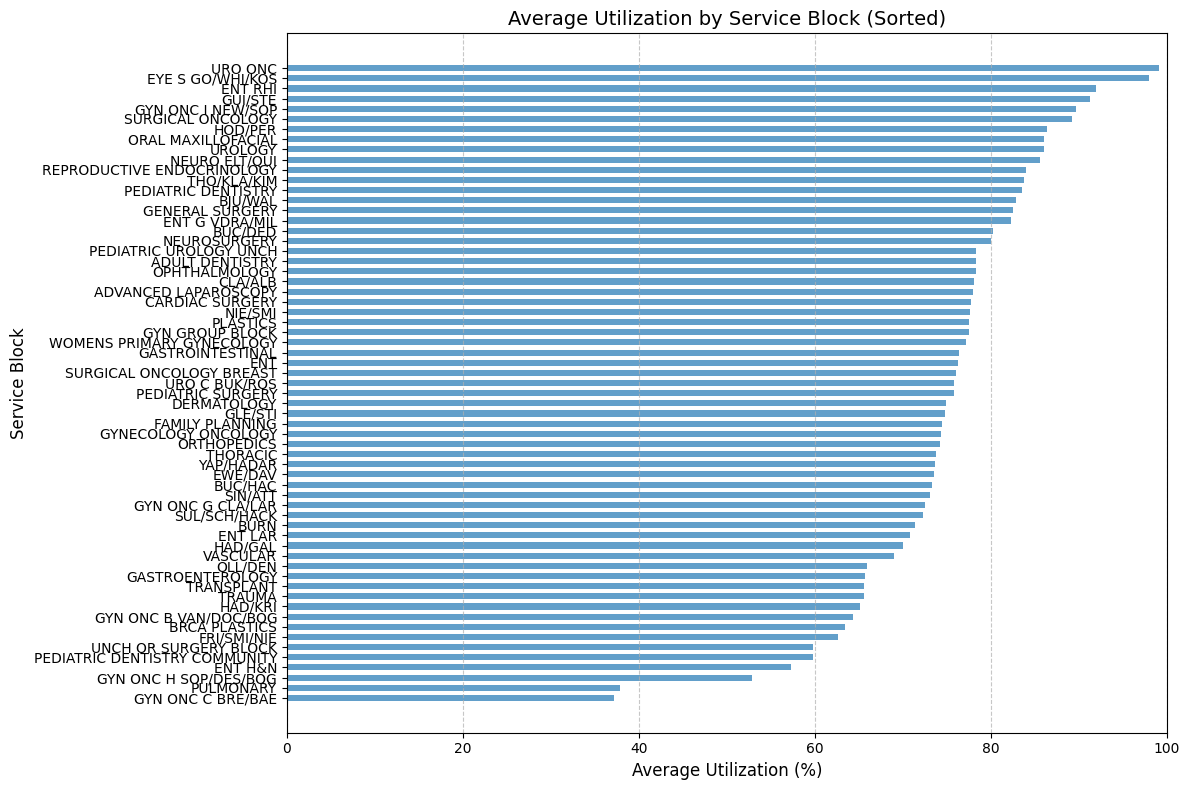

In [ ]:
# prompt: read the file path "/content/NCSU Periop Filtered (1).xlsx". look at the Block Utilization sheet.
# We are going to examine allocation and which service group gets the most average time per week. please record a week as a 7 day period. index 1/1/24 as day of the week 0, and 1/7/24 as day of the week 6, 1/8/24 as day 0, etc.
# begin by reading the column called "Day of snapshot_date_DS" listed in column A. identify the "service_block_name" listed for this date in column D. record the value in column E (block_available_mins). take the average per week per service type. note the top 5 average services based on average available time.
# for each date and service, rather than looking at available mins, we need to take the sum of columns F, G, H, I. these columns are called "correct_proc_time', "correct_setup_time", "outside_proc_time", and "outside_setup_time". if a cell is empty, skip it. record this data in a new list based on date and service type. call the list "ProcedureTime".
# Now, for each service type and date, we need to divide the ProcedureTime by the available minutes for that day and service. this will provide the utilization. for the top 5 allocated services, find and list the average utilization percentages.
# list all utilizations on average do this for all services. print all utilizations as percentages.


# Read the "Block Utilization" sheet
block = pd.read_excel(excel_file, sheet_name="Block Utilization")

# Rename the 'Day of snapshot_date_DS' column to remove spaces.
block = block.rename(columns={'Day of snapshot_date_DS': 'snapshot_date'})

# Convert 'snapshot_date' to datetime objects
block['snapshot_date'] = pd.to_datetime(block['snapshot_date'])

# Calculate the day of the week (0 for Monday, 6 for Sunday)
block['day_of_week'] = block['snapshot_date'].dt.dayofweek

# Calculate week number
block['week_number'] = (block['snapshot_date'].dt.dayofyear - 1) // 7

# Calculate ProcedureTime
block['ProcedureTime'] = block[['correct_proc_time', 'correct_setup_time', 'overbook_proc_time', 'overbook_setup_time']].sum(axis=1)

# Group by week and service to get average available minutes
weekly_avg_available = block.groupby(['week_number', 'service_block_name'])['block_available_mins'].mean().reset_index()

# Group by service to get overall average available minutes
overall_avg_available = weekly_avg_available.groupby('service_block_name')['block_available_mins'].mean().sort_values(ascending=False)

# Get the top 5 services based on average available time
top_5_services = overall_avg_available.head(5).index.tolist()

# Calculate utilization for all services
block['Utilization'] = block['ProcedureTime'] / block['block_available_mins']

# Calculate average utilization for all services
# We will filter to ensure we do not have 0 or NaN values
avg_utilization_all = block[(block['Utilization'] != 0) & (~block['Utilization'].isna())].groupby('service_block_name')['Utilization'].mean().sort_values(ascending=False)

print("\nAverage Utilization for All Services (Sorted):")
print(avg_utilization_all * 100)  # Display as percentages

# Create a horizontal bar chart with adjusted spacing and sorting
plt.figure(figsize=(12, 8))  # Increased figure size for better spacing

# Sort avg_utilization_all by values in descending order
avg_utilization_all_sorted_for_plot = avg_utilization_all.sort_values(ascending=False)

y_pos = np.arange(len(avg_utilization_all_sorted_for_plot))
plt.barh(y_pos, avg_utilization_all_sorted_for_plot * 100, align='center', alpha=0.7, height=0.6)  # Reduced bar height for spacing
plt.yticks(y_pos, avg_utilization_all_sorted_for_plot.index)  # Use sorted index
plt.xlabel('Average Utilization (%)', fontsize=12)  # Added fontsize
plt.ylabel('Service Block', fontsize=12)  # Added label and fontsize
plt.title('Average Utilization by Service Block (Sorted)', fontsize=14)  # Increased fontsize
plt.xlim(0, 100)  # Set x-axis limits for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Added a grid for better readability

# Invert the y-axis to have the highest value on top
plt.gca().invert_yaxis()

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Utilization at OR 4th Floor by Month


Average Utilization for Top 5 Services (Sorted):
service_block_name
ENT             145.768805
NEUROSURGERY    123.424067
ORTHOPEDICS      88.617158
CLA/ALB          78.125097
UNBLOCKED         1.721601
Name: Utilization, dtype: float64

Average Utilization for All Services (Sorted):
service_block_name
CARDIAC SURGERY             151.514959
ENT                         145.768805
UROLOGY                     136.443877
SURGICAL ONCOLOGY           132.141263
NEUROSURGERY                123.424067
GASTROINTESTINAL            112.328785
PLASTICS                    106.772011
THORACIC                    101.829877
TRANSPLANT                  101.468514
ORAL MAXILLOFACIAL          101.347038
URO ONC                      99.166667
GENERAL SURGERY              96.642361
VASCULAR                     93.809818
GYNECOLOGY ONCOLOGY          93.041695
GUI/STE                      91.291667
PEDIATRIC DENTISTRY          90.970464
GYN ONC I NEW/SOP            89.666667
ORTHOPEDICS                  88.6

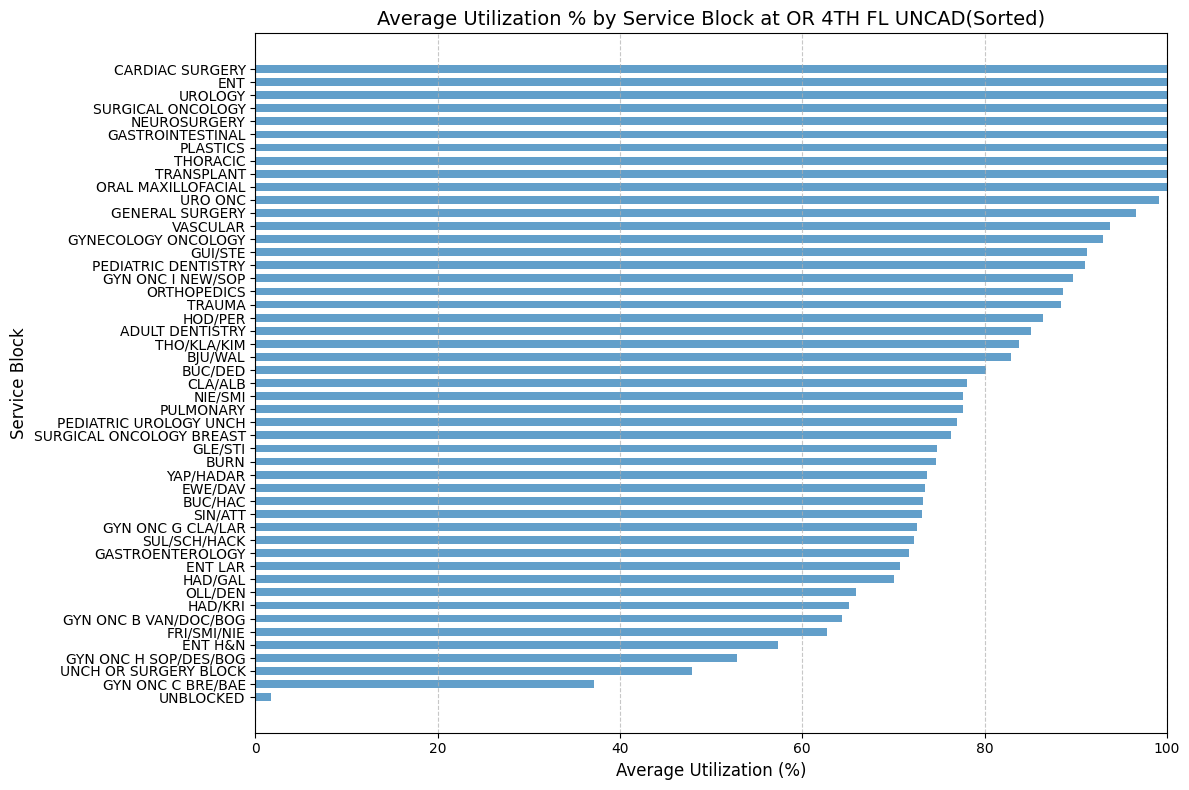

In [ ]:
# prompt: Look at the Block Utilization sheet.
# We are going to examine allocation and which service group gets the most average time per week. please record a week as a 7 day period. index 1/1/24 as day of the week 0, and 1/7/24 as day of the week 6, 1/8/24 as day 0, etc.
# begin by reading the column called "Day of snapshot_date_DS" listed in column A. identify the "service_block_name" listed for this date in column D. record the value in column E (block_available_mins). take the average per week per service type. note the top 5 average services based on average available time.
# for each date and service, rather than looking at available mins, we need to take the sum of columns F, G, H, I. these columns are called "correct_proc_time', "correct_setup_time", "outside_proc_time", and "outside_setup_time". if a cell is empty, skip it. record this data in a new list based on date and service type. call the list "ProcedureTime".
# Now, for each service type and date, we need to divide the ProcedureTime by the available minutes for that day and service. this will provide the utilization. for the top 5 allocated services, find and list the average utilization percentages.
# list all utilizations on average do this for all services. print all utilizations as percentages.


# Read the "Block Utilization" sheet
block = pd.read_excel(excel_file, sheet_name="Block Utilization")

# Filter the DataFrame for "OR 4TH FL UNCAD"
or_4th_fl = block[block['location_name'] == 'OR 4TH FL UNCAD']

# Rename the 'Day of snapshot_date_DS' column to remove spaces.
or_4th_fl = or_4th_fl.rename(columns={'Day of snapshot_date_DS': 'snapshot_date'})

# Convert 'snapshot_date' to datetime objects
or_4th_fl['snapshot_date'] = pd.to_datetime(or_4th_fl['snapshot_date'])

# Calculate the day of the week (0 for Monday, 6 for Sunday)
or_4th_fl['day_of_week'] = or_4th_fl['snapshot_date'].dt.dayofweek

# Calculate week number
or_4th_fl['week_number'] = (or_4th_fl['snapshot_date'].dt.dayofyear - 1) // 7

# Calculate ProcedureTime
or_4th_fl['ProcedureTime'] = or_4th_fl[['correct_proc_time', 'correct_setup_time', 'outside_proc_time', 'outside_setup_time']].sum(axis=1)

# Group by week and service to get average available minutes
weekly_avg_available = or_4th_fl.groupby(['week_number', 'service_block_name'])['block_available_mins'].mean().reset_index()

# Group by service to get overall average available minutes
overall_avg_available = weekly_avg_available.groupby('service_block_name')['block_available_mins'].mean().sort_values(ascending=False)

# Get the top 5 services based on average available time
top_5_services = overall_avg_available.head(5).index.tolist()

# Calculate utilization for all services
or_4th_fl['Utilization'] = or_4th_fl['ProcedureTime'] / or_4th_fl['block_available_mins']

# Calculate average utilization for top 5 services
# We will filter to ensure we do not have 0 or NaN values
avg_utilization_top5 = or_4th_fl[(or_4th_fl['service_block_name'].isin(top_5_services)) & (or_4th_fl['Utilization'] != 0) & (~or_4th_fl['Utilization'].isna())].groupby('service_block_name')['Utilization'].mean().sort_values(ascending=False)

# Calculate average utilization for all services
# We will filter to ensure we do not have 0 or NaN values
avg_utilization_all = or_4th_fl[(or_4th_fl['Utilization'] != 0) & (~or_4th_fl['Utilization'].isna())].groupby('service_block_name')['Utilization'].mean().sort_values(ascending=False)

print("Average Utilization for Top 5 Services (Sorted):")
print(avg_utilization_top5 * 100)  # Display as percentages

print("\nAverage Utilization for All Services (Sorted):")
print(avg_utilization_all * 100)  # Display as percentages

# Create a horizontal bar chart with adjusted spacing and sorting
plt.figure(figsize=(12, 8))  # Increased figure size for better spacing

# Sort avg_utilization_all by values in descending order
avg_utilization_all_sorted_for_plot = avg_utilization_all.sort_values(ascending=False)

y_pos = np.arange(len(avg_utilization_all_sorted_for_plot))
plt.barh(y_pos, avg_utilization_all_sorted_for_plot * 100, align='center', alpha=0.7, height=0.6)  # Reduced bar height for spacing
plt.yticks(y_pos, avg_utilization_all_sorted_for_plot.index)  # Use sorted index
plt.xlabel('Average Utilization (%)', fontsize=12)  # Added fontsize
plt.ylabel('Service Block', fontsize=12)  # Added label and fontsize
plt.title('Average Utilization % by Service Block at OR 4TH FL UNCAD(Sorted)', fontsize=14)  # Increased fontsize
plt.xlim(0, 100)  # Set x-axis limits for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Added a grid for better readability

# Invert the y-axis to have the highest value on top
plt.gca().invert_yaxis()

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
or_4th_fl

,snapshot_date,location_name,department_block_name,service_block_name,in_block_total_utilization,block_available_mins,correct_proc_time,correct_setup_time,outside_proc_time,outside_setup_time,overbook_proc_time,overbook_setup_time,day_of_week,week_number,ProcedureTime,Utilization
8,2023-08-01,OR 4TH FL UNCAD,DEPT OF SURGERY,TRANSPLANT,IN-BLOCK,NaN,NaN,NaN,291.0,NaN,NaN,NaN,1,30,291.0,NaN
9,2023-08-01,OR 4TH FL UNCAD,DEPT OF SURGERY,TRANSPLANT,TOTAL,NaN,NaN,NaN,291.0,NaN,NaN,NaN,1,30,291.0,NaN
10,2023-08-01,OR 4TH FL UNCAD,DEPT OF SURGERY,TRAUMA,IN-BLOCK,NaN,NaN,NaN,588.0,167.0,NaN,NaN,1,30,755.0,NaN
11,2023-08-01,OR 4TH FL UNCAD,DEPT OF SURGERY,TRAUMA,TOTAL,NaN,NaN,NaN,588.0,167.0,NaN,NaN,1,30,755.0,NaN
12,2023-08-01,OR 4TH FL UNCAD,DEPT OF SURGERY,VASCULAR,IN-BLOCK,NaN,NaN,NaN,153.0,NaN,NaN,NaN,1,30,153.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25616,2024-07-30,OR 4TH FL UNCAD,ORTHOPEDICS,ORTHOPEDICS,TOTAL,NaN,NaN,NaN,640.0,60.0,NaN,NaN,1,30,700.0,NaN
25617,2024-07-30,OR 4TH FL UNCAD,UNBLOCKED,UNBLOCKED,IN-BLOCK,8400.0,NaN,NaN,NaN,NaN,NaN,NaN,1,30,0.0,0.0
25618,2024-07-30,OR 4TH FL UNCAD,UNBLOCKED,UNBLOCKED,TOTAL,8400.0,NaN,NaN,NaN,NaN,NaN,NaN,1,30,0.0,0.0
25619,2024-07-30,OR 4TH FL UNCAD,UROLOGY,UROLOGY,IN-BLOCK,NaN,NaN,NaN,44.0,NaN,NaN,NaN,1,30,44.0,NaN


# Monthly Utilization at Different Location


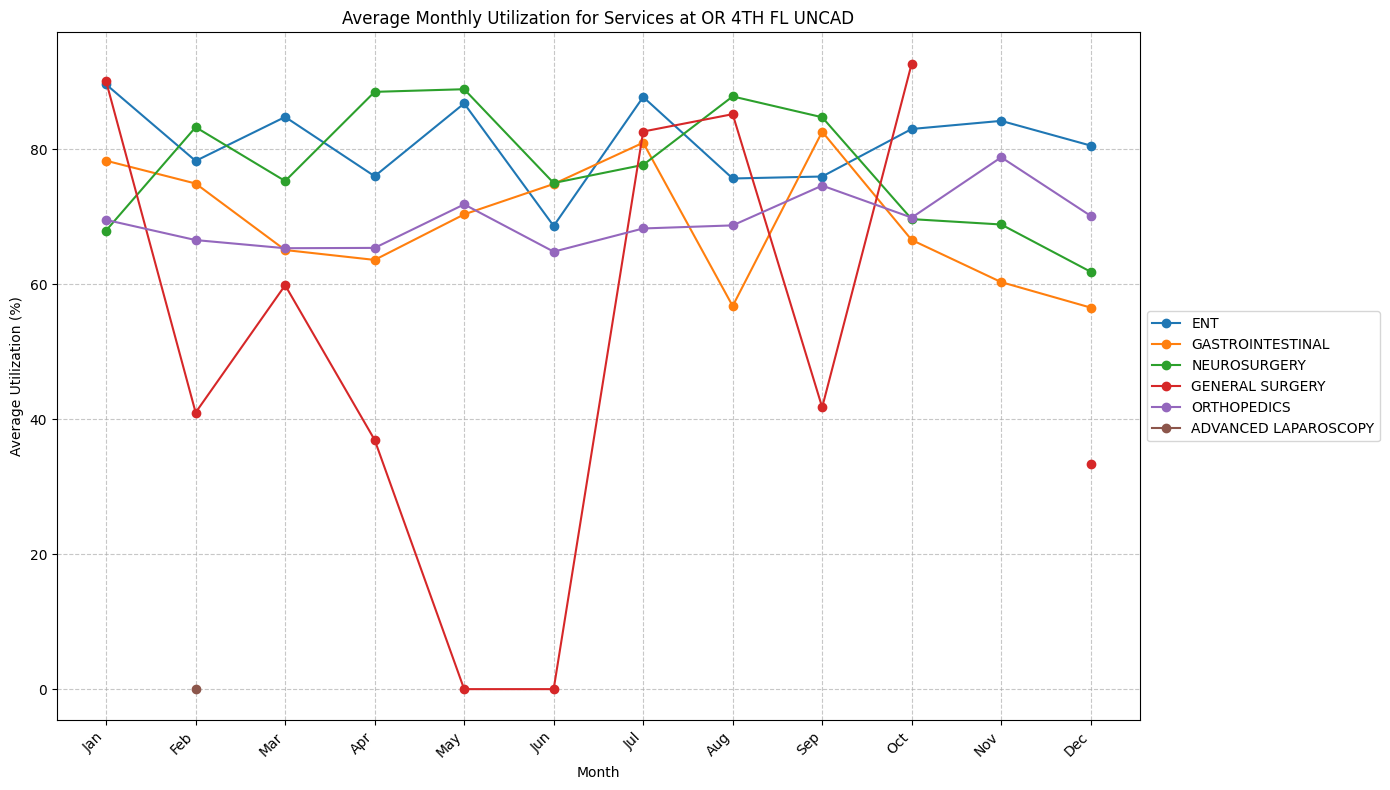

In [ ]:
# prompt: Adjust the code above to show only the graph for the location "OR 4TH FL UNCAD" and also the services "GASTROENTEROLOGY", "GYNECOLOGY ONCOLOGY","NEUROSURGERY","ADVANCED LAPAROSCOPY","ORTHOPEDICS","PLASTICS","PULMONARY",and "THORACIC"

# Assuming 'block' DataFrame is already loaded and processed as in the previous code.
# Reload the original block data
block = pd.read_excel(excel_file, sheet_name="Block Utilization")

# Function to create the line chart
def plot_monthly_utilization(df, location='OR 4TH FL UNCAD'):
    services_to_plot= high_impact_data['service_block_name'].unique()
    #services_to_plot = ["GASTROENTEROLOGY", "GYNECOLOGY ONCOLOGY", "NEUROSURGERY", "ADVANCED LAPAROSCOPY", "ORTHOPEDICS", "PLASTICS", "PULMONARY", "THORACIC"]

    plt.figure(figsize=(14, 8))  # Adjust figure size as needed

    for service in services_to_plot:
        # Filter data for the specific location and service
        service_data = df[(df['location_name'] == location) & (df['service_block_name'] == service)]

        # Check if service_data is empty for this service
        if service_data.empty:
            print(f"No data found for {service} at {location}")
            continue

        service_data = service_data.rename(columns={'Day of snapshot_date_DS': 'snapshot_date'})
        service_data['snapshot_date'] = pd.to_datetime(service_data['snapshot_date'])
        service_data['month'] = service_data['snapshot_date'].dt.month
        service_data['year'] = service_data['snapshot_date'].dt.year
        service_data['ProcedureTime'] = service_data[['correct_proc_time', 'correct_setup_time', 'overbook_proc_time', 'overbook_setup_time']].sum(axis=1)
        service_data['Utilization'] = service_data['ProcedureTime'] / service_data['block_available_mins']

        monthly_utilization = service_data.groupby('month')['Utilization'].mean()

        month_names = {
            1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
        }
        monthly_utilization.index = monthly_utilization.index.map(month_names)

        # Plot the data for the current service
        plt.plot(monthly_utilization.index, monthly_utilization * 100, marker='o', linestyle='-', label=service)


    plt.xlabel("Month")
    plt.ylabel("Average Utilization (%)")
    plt.title(f"Average Monthly Utilization for Services at {location}")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend outside the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
plot_monthly_utilization(block)


# **Break Out Block Time Distribution by Location** : Highlighting Unblocked Service





        location_name         service_block_name  block_available_mins
0   CHILDRENS OR UNCH            ADULT DENTISTRY                   0.0
25  CHILDRENS OR UNCH  WOMENS PRIMARY GYNECOLOGY                   0.0
24  CHILDRENS OR UNCH                   VASCULAR                   0.0
19  CHILDRENS OR UNCH                  PULMONARY                   0.0
20  CHILDRENS OR UNCH                 TRANSPLANT                   0.0
11  CHILDRENS OR UNCH                 OBSTETRICS                   0.0
1   CHILDRENS OR UNCH             ANESTHESIOLOGY                   0.0
12  CHILDRENS OR UNCH              OPHTHALMOLOGY                   0.0
7   CHILDRENS OR UNCH        HEMATOLOGY ONCOLOGY                   0.0
8   CHILDRENS OR UNCH    MATERNAL-FETAL MEDICINE                   0.0
3   CHILDRENS OR UNCH            CARDIAC SURGERY                   0.0
6   CHILDRENS OR UNCH           GASTROENTEROLOGY                   0.0
5   CHILDRENS OR UNCH           EYE S GO/WHI/KOS                 600.0
17

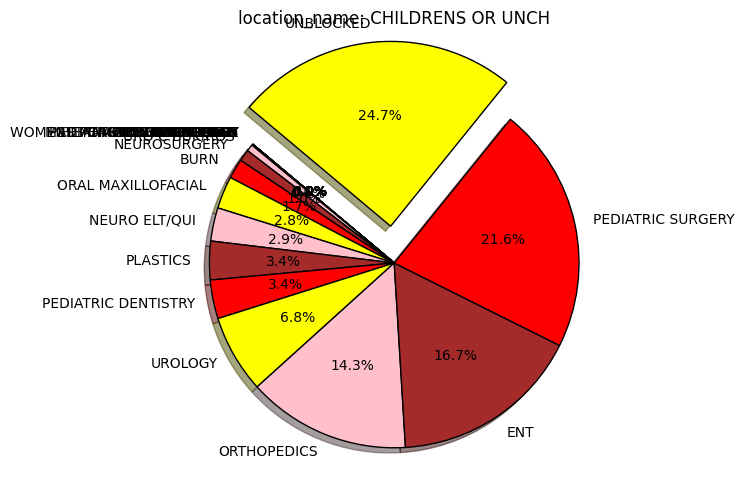

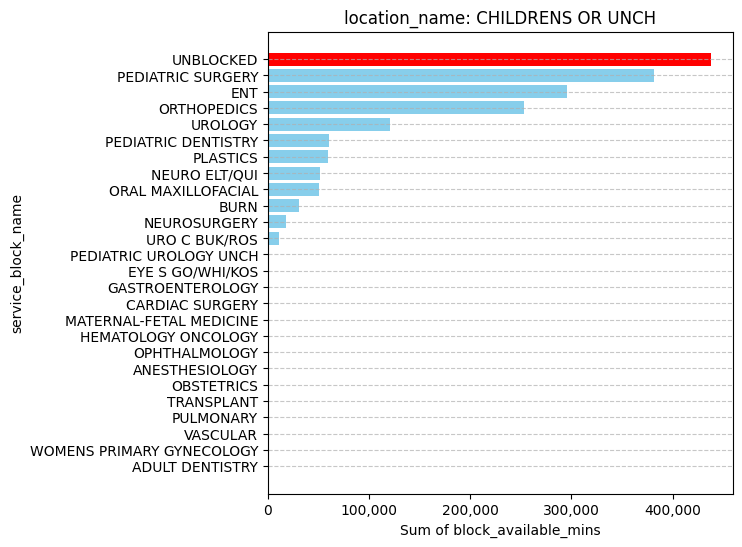





           location_name          service_block_name  block_available_mins
41  HBR Hospital OR UNCH               PELVIC HEALTH                   0.0
31  HBR Hospital OR UNCH            GASTROINTESTINAL                   0.0
30  HBR Hospital OR UNCH            GASTROENTEROLOGY                   0.0
38  HBR Hospital OR UNCH                  OBSTETRICS                   0.0
27  HBR Hospital OR UNCH                  CARDIOLOGY                   0.0
28  HBR Hospital OR UNCH                         ENT                   0.0
42  HBR Hospital OR UNCH  REPRODUCTIVE ENDOCRINOLOGY                1200.0
32  HBR Hospital OR UNCH             GENERAL SURGERY                3120.0
34  HBR Hospital OR UNCH                  GYNECOLOGY                3240.0
36  HBR Hospital OR UNCH    HOLD - NO ELECTIVE CASES               11280.0
35  HBR Hospital OR UNCH          HOLD - 1WK RELEASE               17520.0
33  HBR Hospital OR UNCH             GYN GROUP BLOCK               23590.0
37  HBR Hospital OR U

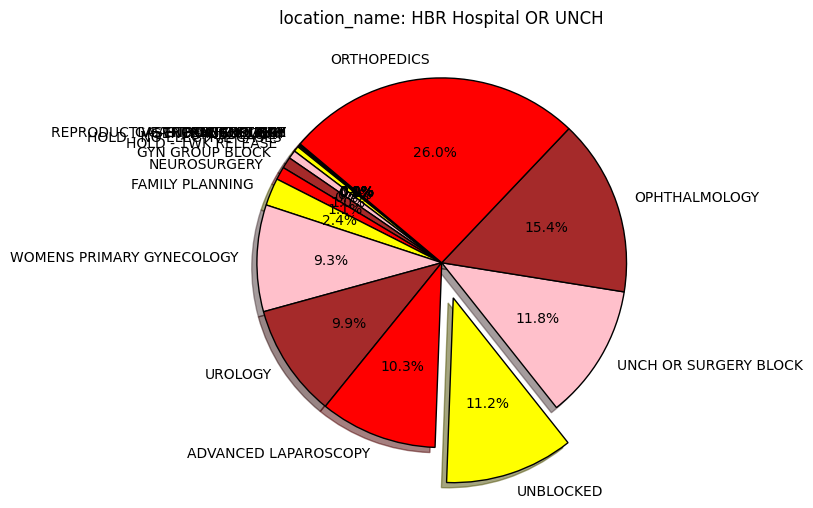

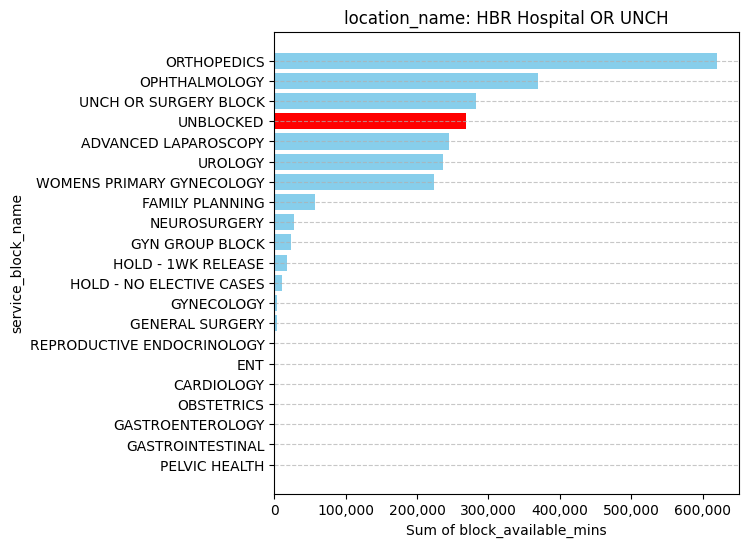





       location_name       service_block_name  block_available_mins
93   OR 4TH FL UNCAD            PELVIC HEALTH                   0.0
91   OR 4TH FL UNCAD        PEDIATRIC SURGERY                   0.0
82   OR 4TH FL UNCAD  MATERNAL-FETAL MEDICINE                   0.0
85   OR 4TH FL UNCAD               OBSTETRICS                   0.0
87   OR 4TH FL UNCAD            OPHTHALMOLOGY                   0.0
..               ...                      ...                   ...
103  OR 4TH FL UNCAD                   TRAUMA              460260.0
83   OR 4TH FL UNCAD             NEUROSURGERY              551218.0
89   OR 4TH FL UNCAD              ORTHOPEDICS              599280.0
59   OR 4TH FL UNCAD                      ENT              693300.0
104  OR 4TH FL UNCAD                UNBLOCKED             5243650.0

[64 rows x 3 columns]


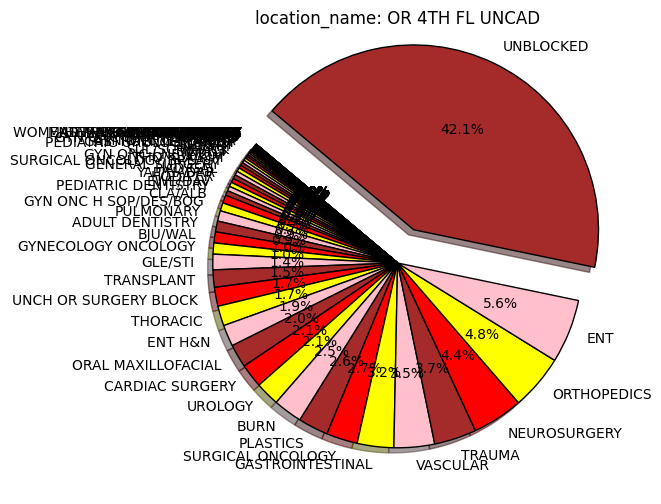

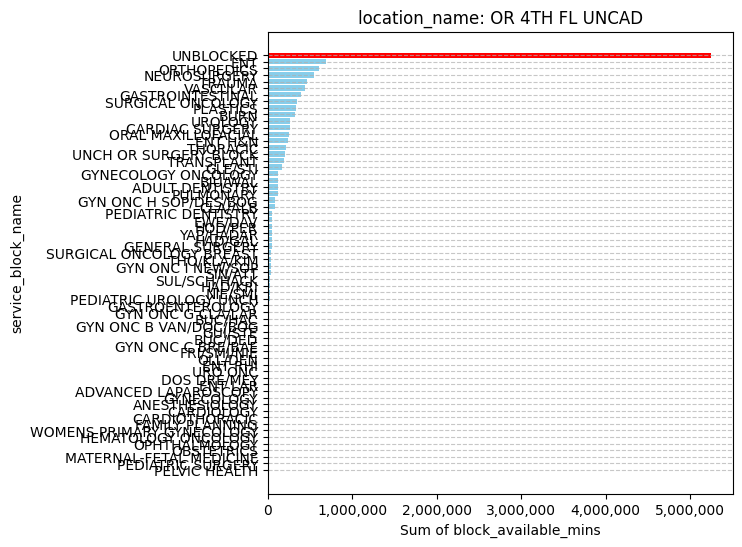





    location_name             service_block_name  block_available_mins
122   OR ACC UNCH              PEDIATRIC SURGERY                   0.0
117   OR ACC UNCH               GASTROINTESTINAL                   0.0
116   OR ACC UNCH                        ENT RHI                4560.0
115   OR ACC UNCH                 ENT G VDRA/MIL                4560.0
118   OR ACC UNCH                   NEUROSURGERY                6690.0
113   OR ACC UNCH                    DERMATOLOGY               11940.0
129   OR ACC UNCH                       VASCULAR               14280.0
121   OR ACC UNCH  PEDIATRIC DENTISTRY COMMUNITY               16830.0
127   OR ACC UNCH          UNCH OR SURGERY BLOCK               22110.0
120   OR ACC UNCH            PEDIATRIC DENTISTRY               34980.0
123   OR ACC UNCH                       PLASTICS               40430.0
111   OR ACC UNCH                ADULT DENTISTRY               51990.0
124   OR ACC UNCH              SURGICAL ONCOLOGY               53160.0
12

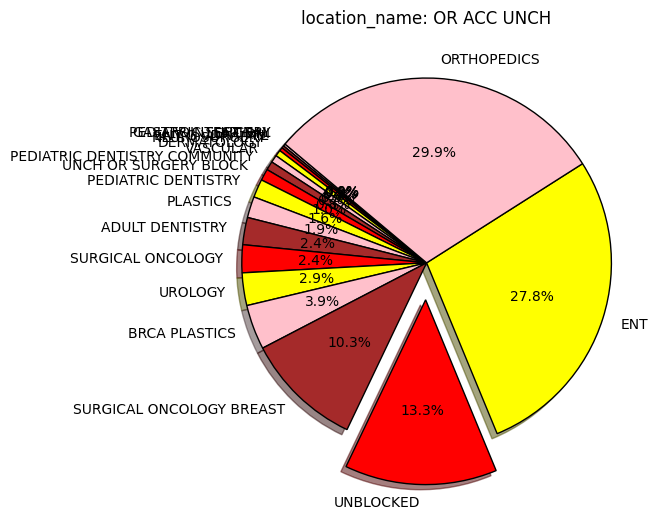

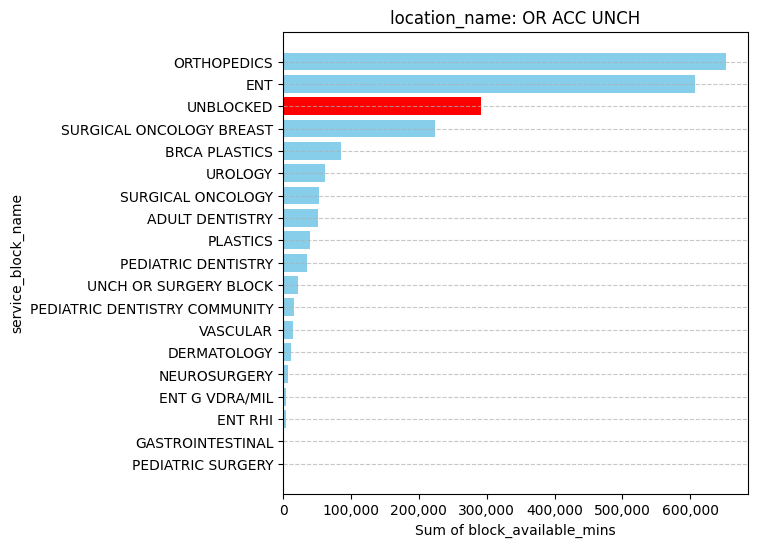

In [ ]:


# Pivot the DataFrame for better visualization
pivot_df = TAbyService_sorted.pivot(index='location_name', columns='service_block_name', values='block_available_mins')

# Get unique categories
categories = TAbyService_sorted['location_name'].unique()

# Choose the subcategory to highlight
highlight_subcategory = 'UNBLOCKED'


# Create individual plots for each category
for category in categories:
    # Filter data for the current category
    category_df = TAbyService_sorted[TAbyService_sorted['location_name'] == category]
    category_df = category_df.sort_values(by=['block_available_mins'],ascending=True)
    # Assign colors: highlight one specific subcategory
    colors = ['red' if subcat == highlight_subcategory else 'skyblue' for subcat in category_df['service_block_name']]
    print('\n')
    print('\n')
    print(category_df)

    #Create Pie Plot

    # Sample Data
    labels = category_df['service_block_name']
    values = category_df['block_available_mins']
    explode = [0.2 if label == highlight_subcategory else 0 for label in labels]

    # Create Pie Chart
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140,
        explode=explode, shadow=True, colors=['red', 'yellow', 'pink', 'brown'],
        wedgeprops={'edgecolor': 'black'})

    # Add Title
    plt.title(f'location_name: {category}')

    # Show Plot
    plt.show()


    # Plot
    plt.figure(figsize=(6, 6))
    plt.barh(category_df['service_block_name'], category_df['block_available_mins'], color=colors)

    # Add value labels to bars
    # for bars in [bars1, bars2]:
    #     for bar in bars:
    #         height = bar.get_height()
    #plt.text()
        # bar.get_x() + bar.get_width()/2, height, f"{height:,}",
    #                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Titles and labels
    plt.title(f'location_name: {category}')
    plt.xlabel('Sum of block_available_mins')
    plt.ylabel('service_block_name')
    plt.xticks(rotation=0)
    # Format x-axis with comma separator
    plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()

#Scheduled Time Distribution - Total

               service_block_name  sched_minutes
25                  PELVIC HEALTH          396.0
6                  CARDIOTHORACIC          944.0
2                  ANESTHESIOLOGY         1320.0
5                      CARDIOLOGY         1693.0
15            HEMATOLOGY ONCOLOGY         2758.0
7                     DERMATOLOGY         3537.0
28     REPRODUCTIVE ENDOCRINOLOGY         4832.0
23  PEDIATRIC DENTISTRY COMMUNITY         4954.0
18                     OBSTETRICS         5608.0
16        MATERNAL-FETAL MEDICINE         7146.0
10               GASTROENTEROLOGY        12351.0
9                 FAMILY PLANNING        20896.0
13                     GYNECOLOGY        23268.0
27                      PULMONARY        52017.0
22            PEDIATRIC DENTISTRY        62970.0
0                 ADULT DENTISTRY        73651.0
1            ADVANCED LAPAROSCOPY       106108.0
36      WOMENS PRIMARY GYNECOLOGY       117303.0
3                            BURN       118044.0
30       SURGICAL ON

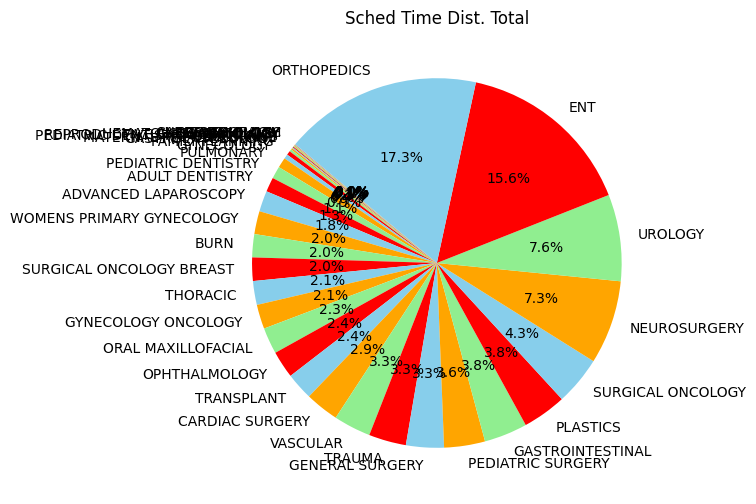

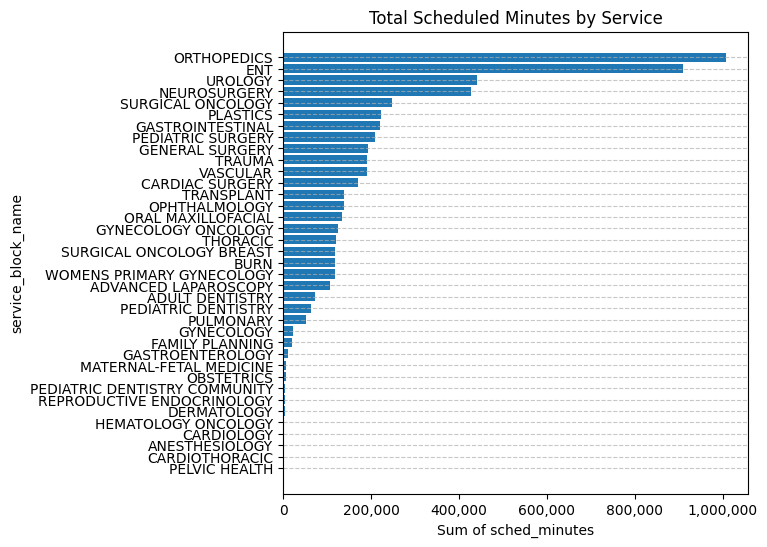

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


# # Pivot the DataFrame for better visualization
# cat_df = CTAbyService_sorted.pivot(index='location_name', columns='service_block_name', values='sched_minutes')

CTAbyS = df_case.groupby(['service_block_name'])['sched_minutes'].sum().reset_index()
CTAbyS = CTAbyS.sort_values(by=['sched_minutes'],ascending=True)
print(CTAbyS)

#Create Pie Plot

# Sample Data
labels = CTAbyS['service_block_name']
values = CTAbyS['sched_minutes']

# Create Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'lightgreen', 'red'])

# Add Title
plt.title('Sched Time Dist. Total')

# Show Plot
plt.show()


# Plot
plt.figure(figsize=(6, 6))
plt.barh(CTAbyS['service_block_name'], CTAbyS['sched_minutes'])

# Titles and labels
plt.title('Total Scheduled Minutes by Service')
plt.xlabel('Sum of sched_minutes')
plt.ylabel('service_block_name')
plt.xticks(rotation=0)
# Format x-axis with comma separator
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# Scheduled Time Distribution by Service and Location

<ipython-input-57-f09df81a92f1>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_df = CTAbyService_sorted[TAbyService_sorted['location_name'] == category]


        location_name         service_block_name  sched_minutes
7   CHILDRENS OR UNCH        GYNECOLOGY ONCOLOGY           56.0
3   CHILDRENS OR UNCH            CARDIAC SURGERY           81.0
19  CHILDRENS OR UNCH          SURGICAL ONCOLOGY          106.0
0   CHILDRENS OR UNCH            ADULT DENTISTRY          150.0
1   CHILDRENS OR UNCH             ANESTHESIOLOGY          196.0
6   CHILDRENS OR UNCH           GASTROINTESTINAL          257.0
11  CHILDRENS OR UNCH                 OBSTETRICS          299.0
20  CHILDRENS OR UNCH                   THORACIC          373.0
24  CHILDRENS OR UNCH                   VASCULAR          572.0
5   CHILDRENS OR UNCH           GASTROENTEROLOGY          692.0
18  CHILDRENS OR UNCH                  PULMONARY          702.0
22  CHILDRENS OR UNCH                     TRAUMA         1120.0
8   CHILDRENS OR UNCH        HEMATOLOGY ONCOLOGY         1750.0
12  CHILDRENS OR UNCH              OPHTHALMOLOGY         1815.0
25  CHILDRENS OR UNCH  WOMENS PRIMARY GY

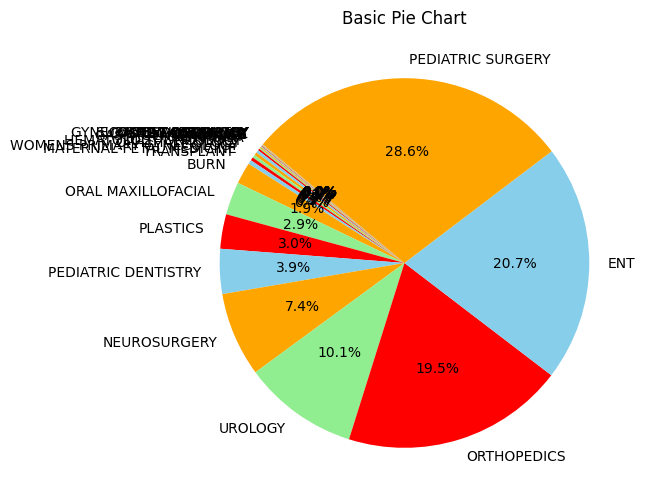

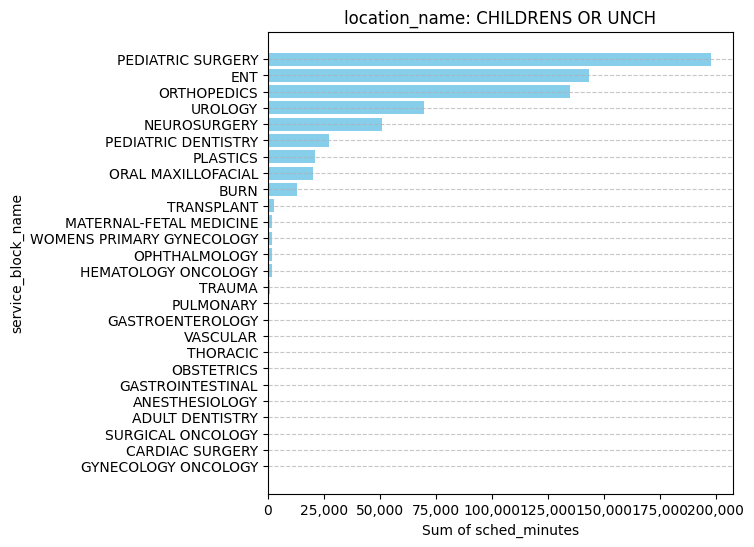

           location_name          service_block_name  sched_minutes
37  HBR Hospital OR UNCH           PEDIATRIC SURGERY          130.0
38  HBR Hospital OR UNCH               PELVIC HEALTH          321.0
30  HBR Hospital OR UNCH            GASTROINTESTINAL         1033.0
44       OR 4TH FL UNCAD              ANESTHESIOLOGY         1124.0
27  HBR Hospital OR UNCH                  CARDIOLOGY         1693.0
34  HBR Hospital OR UNCH                  OBSTETRICS         1962.0
32  HBR Hospital OR UNCH                  GYNECOLOGY         2640.0
29  HBR Hospital OR UNCH            GASTROENTEROLOGY         2757.0
39  HBR Hospital OR UNCH  REPRODUCTIVE ENDOCRINOLOGY         4832.0
43       OR 4TH FL UNCAD        ADVANCED LAPAROSCOPY         5175.0
33  HBR Hospital OR UNCH                NEUROSURGERY        11739.0
28  HBR Hospital OR UNCH             FAMILY PLANNING        19422.0
42       OR 4TH FL UNCAD             ADULT DENTISTRY        50941.0
41  HBR Hospital OR UNCH   WOMENS PRIMARY GYNECO

<ipython-input-57-f09df81a92f1>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_df = CTAbyService_sorted[TAbyService_sorted['location_name'] == category]


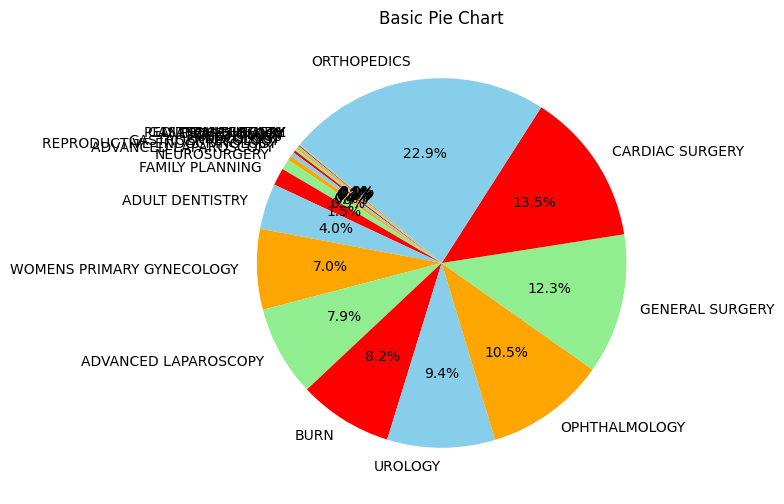

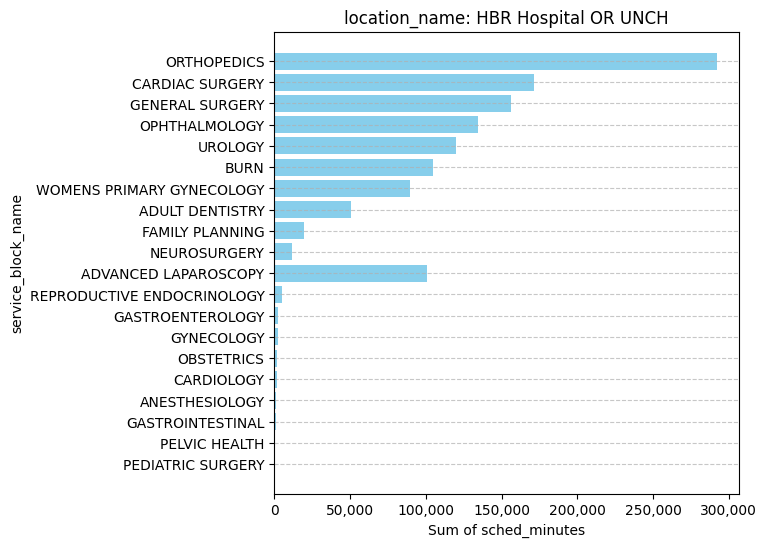

<ipython-input-57-f09df81a92f1>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_df = CTAbyService_sorted[TAbyService_sorted['location_name'] == category]


      location_name             service_block_name  sched_minutes
64  OR 4TH FL UNCAD                  PELVIC HEALTH           75.0
78      OR ACC UNCH               GASTROINTESTINAL          136.0
83      OR ACC UNCH              PEDIATRIC SURGERY          311.0
87      OR ACC UNCH                         TRAUMA          471.0
47  OR 4TH FL UNCAD                 CARDIOTHORACIC          944.0
55  OR 4TH FL UNCAD            HEMATOLOGY ONCOLOGY         1008.0
49  OR 4TH FL UNCAD                FAMILY PLANNING         1474.0
59  OR 4TH FL UNCAD                  OPHTHALMOLOGY         2708.0
58  OR 4TH FL UNCAD                     OBSTETRICS         3347.0
76      OR ACC UNCH                    DERMATOLOGY         3537.0
79      OR ACC UNCH                   NEUROSURGERY         3732.0
82      OR ACC UNCH  PEDIATRIC DENTISTRY COMMUNITY         4954.0
56  OR 4TH FL UNCAD        MATERNAL-FETAL MEDICINE         5179.0
50  OR 4TH FL UNCAD               GASTROENTEROLOGY         8902.0
63  OR 4TH

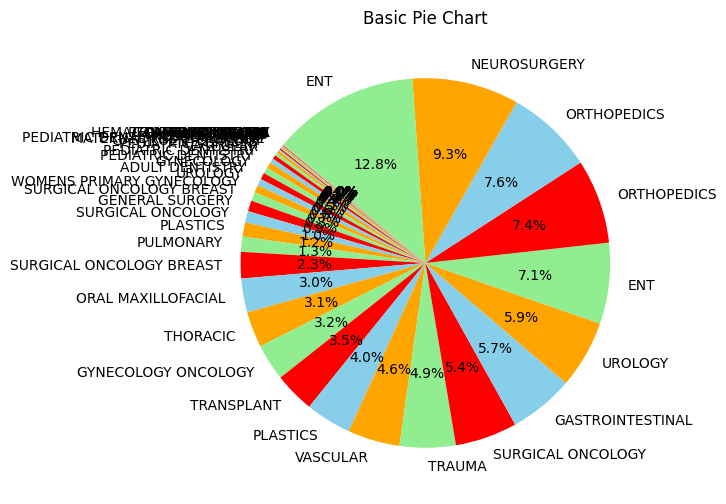

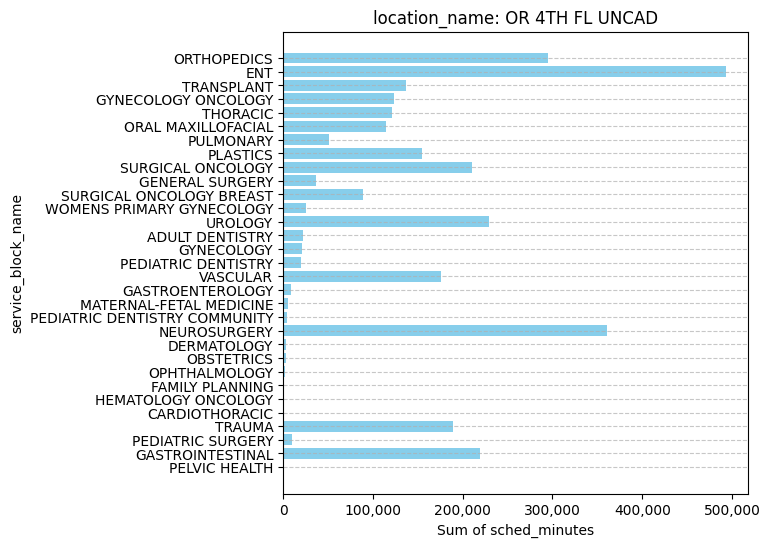

Empty DataFrame
Columns: [location_name, service_block_name, sched_minutes]
Index: []


<ipython-input-57-f09df81a92f1>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_df = CTAbyService_sorted[TAbyService_sorted['location_name'] == category]


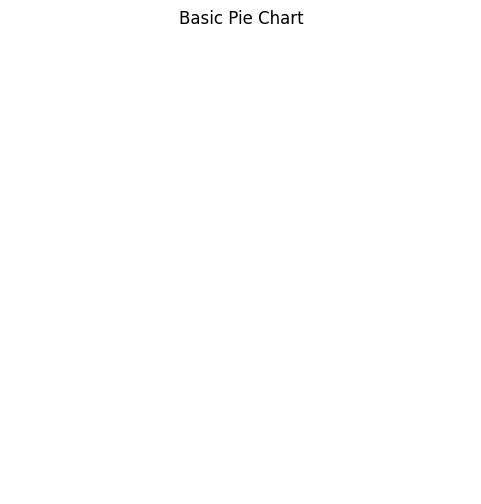

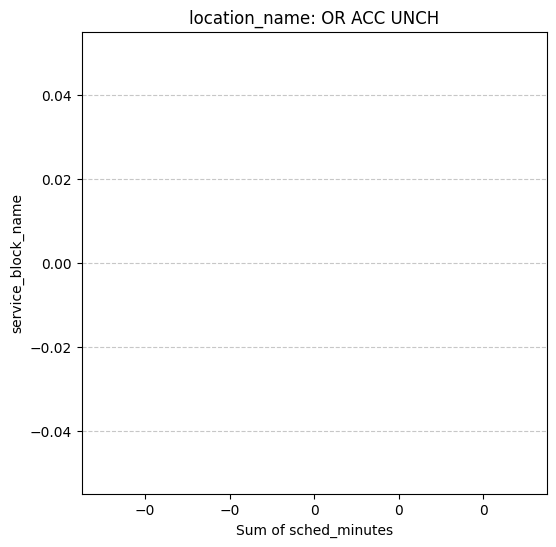

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


# Pivot the DataFrame for better visualization
pivot_df = CTAbyService_sorted.pivot(index='location_name', columns='service_block_name', values='sched_minutes')

# Get unique categories
categories = CTAbyService_sorted['location_name'].unique()

# Choose the subcategory to highlight
highlight_subcategory = 'UNBLOCKED'



# Create individual plots for each category
for category in categories:
    # Filter data for the current category
    cat_df = CTAbyService_sorted[TAbyService_sorted['location_name'] == category]
    cat_df = cat_df.sort_values(by=['sched_minutes'],ascending=True)
    # Assign colors: highlight one specific subcategory
    colors = ['red' if subcat == highlight_subcategory else 'skyblue' for subcat in cat_df['service_block_name']]
    print(cat_df)

    #Create Pie Plot

    # Sample Data
    labels = cat_df['service_block_name']
    values = cat_df['sched_minutes']

    # Create Pie Chart
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'lightgreen', 'red'])

    # Add Title
    plt.title('Basic Pie Chart')

    # Show Plot
    plt.show()


    # Plot
    plt.figure(figsize=(6, 6))
    plt.barh(cat_df['service_block_name'], cat_df['sched_minutes'], color=colors)

    # Titles and labels
    plt.title(f'location_name: {category}')
    plt.xlabel('Sum of sched_minutes')
    plt.ylabel('service_block_name')
    plt.xticks(rotation=0)
    # Format x-axis with comma separator
    plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()

# Compare Total Block Available Minutes to Scheduled Minutes and Unblocked Service Time by Location

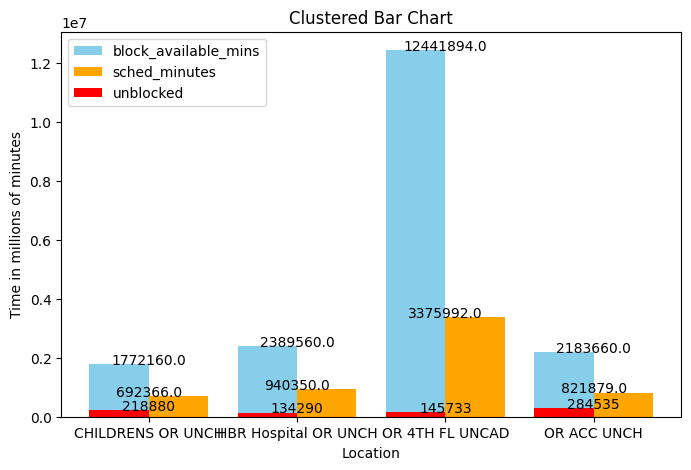

,location_name,block_available_mins,Unblocked,sched_minutes
0,CHILDRENS OR UNCH,1772160.0,218880,692366.0
1,HBR Hospital OR UNCH,2389560.0,134290,940350.0
2,OR 4TH FL UNCAD,12441894.0,145733,3375992.0
3,OR ACC UNCH,2183660.0,284535,821879.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by location and calculate total block available minutes
rb = df_block.groupby(['location_name'])['block_available_mins'].sum().reset_index()
BlockTA_sorted = rb.sort_values(by=['block_available_mins'])
BlockTA_sorted = rb.sort_values(by=['location_name'])
BlockTA_sorted['Unblocked'] = [218880,134290,145733,284535]

# Group by location and calculate total scheduled minutes
rc = df_case.groupby(['location_name'])['sched_minutes'].sum().reset_index()
CaseTS_sorted = rc.sort_values(by=['sched_minutes'])
CaseTS_sorted = rc.sort_values(by=['location_name'])
CaseTS_sorted

merged = pd.merge(BlockTA_sorted,CaseTS_sorted, on='location_name')


# function to add value labels
def addlabels(x,y):
    for i in range(len(merged)):
        plt.text(i, y[i], y[i], ha = 'center')

# Plot as a clustered bar chart
x = np.arange(len(merged['location_name']))  # Numeric positions for categories
width = 0.4  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))

# Create bars for each group
ax.bar(x - width/2, merged['block_available_mins'], width, label='block_available_mins', color='skyblue')
ax.bar(x + width/2, merged['sched_minutes'], width, label='sched_minutes', color='orange')
ax.bar(x - width/2, merged['Unblocked'], width, label='unblocked', color='red')


 # calling the function to add value labels
addlabels(merged['sched_minutes'], merged['sched_minutes'])
addlabels(merged['block_available_mins'], merged['block_available_mins'])
addlabels(merged['Unblocked'], merged['Unblocked'])

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(merged['location_name'])
ax.set_xlabel('Location')
ax.set_ylabel('Time in millions of minutes')
ax.set_title('Clustered Bar Chart')
ax.legend()

# Show plot
plt.show()

merged

# Total Actual Procedure Time
vs
#Total Setup Time
vs
#Scheduled Time

In [ ]:
#Change all blanks to 0s
df_block_new = df_block.fillna(0)

# Create 3 new columns and populate with...

# Total Procedure Time - Sum of correct, outside, and over book
df_block_new['total_procedure_time'] = df_block_new[['correct_proc_time', 'outside_proc_time', 'overbook_proc_time']].sum(axis=1)
# Total Setup Time - Sum of correct, outside, and over book
df_block_new['total_setup_time'] = df_block_new[['correct_setup_time', 'outside_setup_time', 'overbook_setup_time']].sum(axis=1)
# Total Time - Sum of Procedure and Setup Time
df_block_new['total_time'] = df_block_new['total_procedure_time'] + df_block_new['total_setup_time']


df_block_new

,Day of snapshot_date_DS,location_name,department_block_name,service_block_name,in_block_total_utilization,block_available_mins,correct_proc_time,correct_setup_time,outside_proc_time,outside_setup_time,overbook_proc_time,overbook_setup_time,total_procedure_time,total_setup_time,total_time
0,2023-08-01,CHILDRENS OR UNCH,DEPT OF SURGERY,PEDIATRIC SURGERY,IN-BLOCK,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
1,2023-08-01,CHILDRENS OR UNCH,DEPT OF SURGERY,PEDIATRIC SURGERY,TOTAL,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0
2,2023-08-01,CHILDRENS OR UNCH,DEPT OF SURGERY,PLASTICS,IN-BLOCK,0.0,0.0,0.0,119.0,0.0,0.0,0.0,119.0,0.0,119.0
3,2023-08-01,CHILDRENS OR UNCH,DEPT OF SURGERY,PLASTICS,TOTAL,0.0,0.0,0.0,119.0,0.0,0.0,0.0,119.0,0.0,119.0
4,2023-08-01,CHILDRENS OR UNCH,DEPT OF SURGERY,TRANSPLANT,IN-BLOCK,0.0,0.0,0.0,241.0,0.0,0.0,0.0,241.0,0.0,241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25616,2024-07-30,OR 4TH FL UNCAD,ORTHOPEDICS,ORTHOPEDICS,TOTAL,0.0,0.0,0.0,640.0,60.0,0.0,0.0,640.0,60.0,700.0
25617,2024-07-30,OR 4TH FL UNCAD,UNBLOCKED,UNBLOCKED,IN-BLOCK,8400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25618,2024-07-30,OR 4TH FL UNCAD,UNBLOCKED,UNBLOCKED,TOTAL,8400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25619,2024-07-30,OR 4TH FL UNCAD,UROLOGY,UROLOGY,IN-BLOCK,0.0,0.0,0.0,44.0,0.0,0.0,0.0,44.0,0.0,44.0


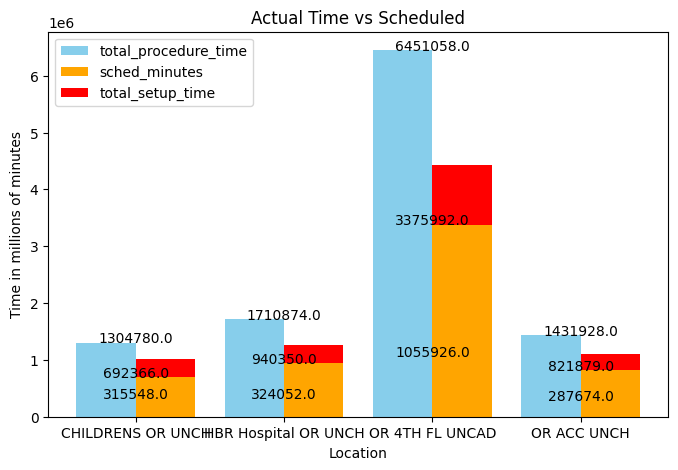

,location_name,total_procedure_time,sched_minutes,total_setup_time
0,CHILDRENS OR UNCH,1304780.0,692366.0,315548.0
1,HBR Hospital OR UNCH,1710874.0,940350.0,324052.0
2,OR 4TH FL UNCAD,6451058.0,3375992.0,1055926.0
3,OR ACC UNCH,1431928.0,821879.0,287674.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by location and calculate total procedure minutes
rb = df_block_new.groupby(['location_name'])['total_procedure_time'].sum().reset_index()
BlockTA_sorted = rb.sort_values(by=['total_procedure_time'])
BlockTA_sorted = rb.sort_values(by=['location_name'])

# Group by location and calculate total setup minutes
rb2 = df_block_new.groupby(['location_name'])['total_setup_time'].sum().reset_index()
BlockPT_sorted = rb2.sort_values(by=['total_setup_time'])
BlockPT_sorted = rb2.sort_values(by=['location_name'])

# Group by location and calculate total scheduled minutes
rc = df_case.groupby(['location_name'])['sched_minutes'].sum().reset_index()
CaseTS_sorted = rc.sort_values(by=['sched_minutes'])
CaseTS_sorted = rc.sort_values(by=['location_name'])
CaseTS_sorted

merged1 = pd.merge(BlockTA_sorted,CaseTS_sorted, on='location_name')
merged = pd.merge(merged1,BlockPT_sorted, on='location_name')

# function to add value labels
def addlabels(x,y):
    for i in range(len(merged)):
        plt.text(i, y[i], y[i], ha = 'center')

# Plot as a clustered bar chart
x = np.arange(len(merged['location_name']))  # Numeric positions for categories
width = 0.4  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))

# Create bars for each group
ax.bar(x - width/2, merged['total_procedure_time'], width, label='total_procedure_time', color='skyblue')
ax.bar(x + width/2, merged['sched_minutes'], width, label='sched_minutes', color='orange')
ax.bar(x + width/2, merged['total_setup_time'], width, bottom=merged['sched_minutes'], label='total_setup_time', color='red')


 # calling the function to add value labels
addlabels(merged['sched_minutes'], merged['sched_minutes'])
addlabels(merged['total_procedure_time'], merged['total_procedure_time'])
addlabels(merged['total_setup_time'], merged['total_setup_time'])

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(merged['location_name'])
ax.set_xlabel('Location')
ax.set_ylabel('Time in millions of minutes')
ax.set_title('Actual Time vs Scheduled')
ax.legend()

# Show plot
plt.show()

merged

# Actual vs Scheduled - Detailed

This is Emily: Lydia, you did this based on the block utilization sheet, but what I had done was based on the case data sheet. I'm adding Actual vs Scheduled in a second block below this one to show what I have done before. Lets chat about this soon. xoxo, gossip girl.

May want to change where in the code sequence this goes, since it doesn't directly affect the block scheduler model (to Emily's knowledge lol). My part is more general suggestions.

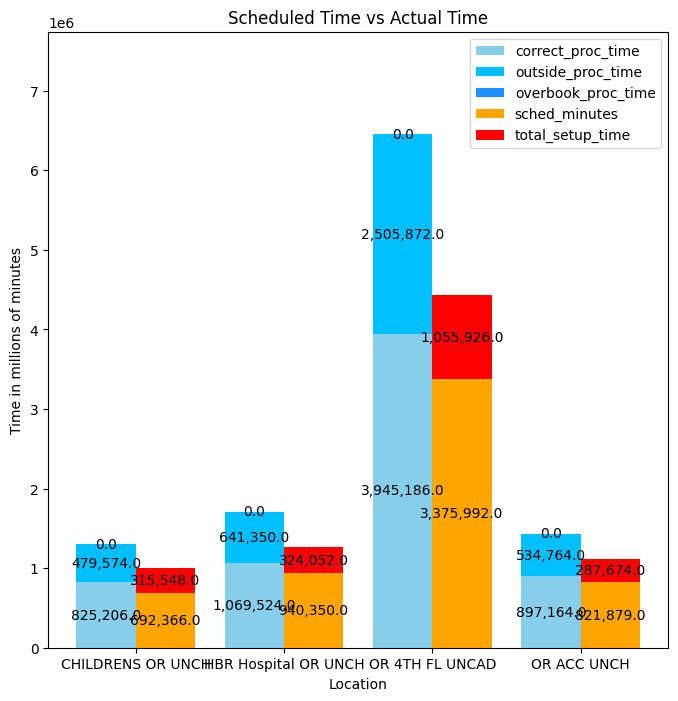

,location_name,correct_proc_time,outside_proc_time,overbook_proc_time,total_setup_time,sched_minutes
0,CHILDRENS OR UNCH,825206.0,479574.0,0.0,315548.0,692366.0
1,HBR Hospital OR UNCH,1069524.0,641350.0,0.0,324052.0,940350.0
2,OR 4TH FL UNCAD,3945186.0,2505872.0,0.0,1055926.0,3375992.0
3,OR ACC UNCH,897164.0,534764.0,0.0,287674.0,821879.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_block=pd.read_excel(excel_file, sheet_name="Block Utilization")

# Group by location and calculate total CORRECT procedure minutes
rbs1 = df_block_new.groupby(['location_name'])['correct_proc_time'].sum().reset_index()
BlockCPT_sorted = rbs1.sort_values(by=['correct_proc_time'])
BlockCPT_sorted = rbs1.sort_values(by=['location_name'])

# Group by location and calculate total OUTSIDE procedure minutes
rbs2 = df_block_new.groupby(['location_name'])['outside_proc_time'].sum().reset_index()
BlockOPT_sorted = rbs2.sort_values(by=['outside_proc_time'])
BlockOPT_sorted = rbs2.sort_values(by=['location_name'])

# Group by location and calculate total OVERBOOK procedure minutes
rbs3 = df_block_new.groupby(['location_name'])['overbook_proc_time'].sum().reset_index()
BlockBPT_sorted = rbs3.sort_values(by=['overbook_proc_time'])
BlockBPT_sorted = rbs3.sort_values(by=['location_name'])

# Group by location and calculate total setup minutes
rb2 = df_block_new.groupby(['location_name'])['total_setup_time'].sum().reset_index()
BlockPT_sorted = rb2.sort_values(by=['total_setup_time'])
BlockPT_sorted = rb2.sort_values(by=['location_name'])

# Group by location and calculate total scheduled minutes
rc = df_case.groupby(['location_name'])['sched_minutes'].sum().reset_index()
CaseTS_sorted = rc.sort_values(by=['sched_minutes'])
CaseTS_sorted = rc.sort_values(by=['location_name'])
CaseTS_sorted

merged3 = pd.merge(BlockCPT_sorted,BlockOPT_sorted, on='location_name')
merged2 = pd.merge(merged3,BlockBPT_sorted, on='location_name')
merged1 = pd.merge(merged2,BlockPT_sorted, on='location_name')
merged = pd.merge(merged1,CaseTS_sorted, on='location_name')

# # function to add value labels
# def addlabels(x,y):
#     for i in range(len(merged)):
#         plt.text(i, y[i], y[i], ha = 'center')



# Plot as a clustered bar chart
x = np.arange(len(merged['location_name']))  # Numeric positions for categories
width = 0.4  # Width of bars

fig, ax = plt.subplots(figsize=(8, 8))

# Create bars for each group
ax.bar(x - width/2, merged['correct_proc_time'], width, label='correct_proc_time', color='skyblue')
ax.bar(x - width/2, merged['outside_proc_time'], width, bottom=merged['correct_proc_time'], label='outside_proc_time', color='deepskyblue')
ax.bar(x - width/2, merged['overbook_proc_time'], width, bottom=np.array(merged['correct_proc_time']) + np.array(merged['outside_proc_time']), label='overbook_proc_time', color='dodgerblue')
ax.bar(x + width/2, merged['sched_minutes'], width, label='sched_minutes', color='orange')
ax.bar(x + width/2, merged['total_setup_time'], width, bottom=merged['sched_minutes'], label='total_setup_time', color='red')

# Set y-axis limit (sum of the max stacked bar + some buffer)
max_height = max(np.array(merged['correct_proc_time']) + np.array(merged['outside_proc_time']) + np.array(merged['overbook_proc_time']))
plt.ylim(0, max_height * 1.2)  # 20% extra space

# Function to add labels
def add_labels(bars, values, bottoms):
    for bar, value, bottom in zip(bars, values, bottoms):
        plt.text(bar.get_x() + bar.get_width() / 2, bottom + value / 2,
                 f"{value:,}", ha='center', va='center', color='black', fontsize=10)

# calling the function to add value labels
bar1 = ax.bar(x - width/2, merged['correct_proc_time'], width, color='skyblue')
add_labels(bar1, merged['correct_proc_time'], [0]*merged['correct_proc_time'])

bar2 = ax.bar(x - width/2, merged['outside_proc_time'], width, bottom=merged['correct_proc_time'], color='deepskyblue')
add_labels(bar2, merged['outside_proc_time'], merged['correct_proc_time'])

bar3 = ax.bar(x - width/2, merged['overbook_proc_time'], width, bottom=np.array(merged['correct_proc_time']) + np.array(merged['outside_proc_time']), color='dodgerblue')
add_labels(bar3, merged['overbook_proc_time'], np.array(merged['correct_proc_time']) + np.array(merged['outside_proc_time']))

bar4 = ax.bar(x + width/2, merged['sched_minutes'], width, color='orange')
add_labels(bar4, merged['sched_minutes'], [0]*merged['sched_minutes'])

bar5 = ax.bar(x + width/2, merged['total_setup_time'], width, bottom=merged['sched_minutes'], color='red')
add_labels(bar5, merged['total_setup_time'], merged['sched_minutes'])


# Formatting
ax.set_xticks(x)
ax.set_xticklabels(merged['location_name'])
ax.set_xlabel('Location')
ax.set_ylabel('Time in millions of minutes')
ax.set_title('Scheduled Time vs Actual Time')
ax.legend()

# Show plot
plt.show()

merged

This code measures discrepencies between scheduled time and case duration, as well as total allocation, total scheduled time, and total used time by service.
Not sure where to go from here? Showing the minutes over/under used shows what exactly? Another factor to consider in reallocation or the need for better surgery length predictors??

The total number of minutes different from scheduled vs duration for all services in 2024 is 453463.0 minutes
The total number of hours different from scheduled vs duration for all services in 2024 is 7557.716666666666 hours
The total number of days different from scheduled vs duration for all services in 2024 is 314.9048611111111 days


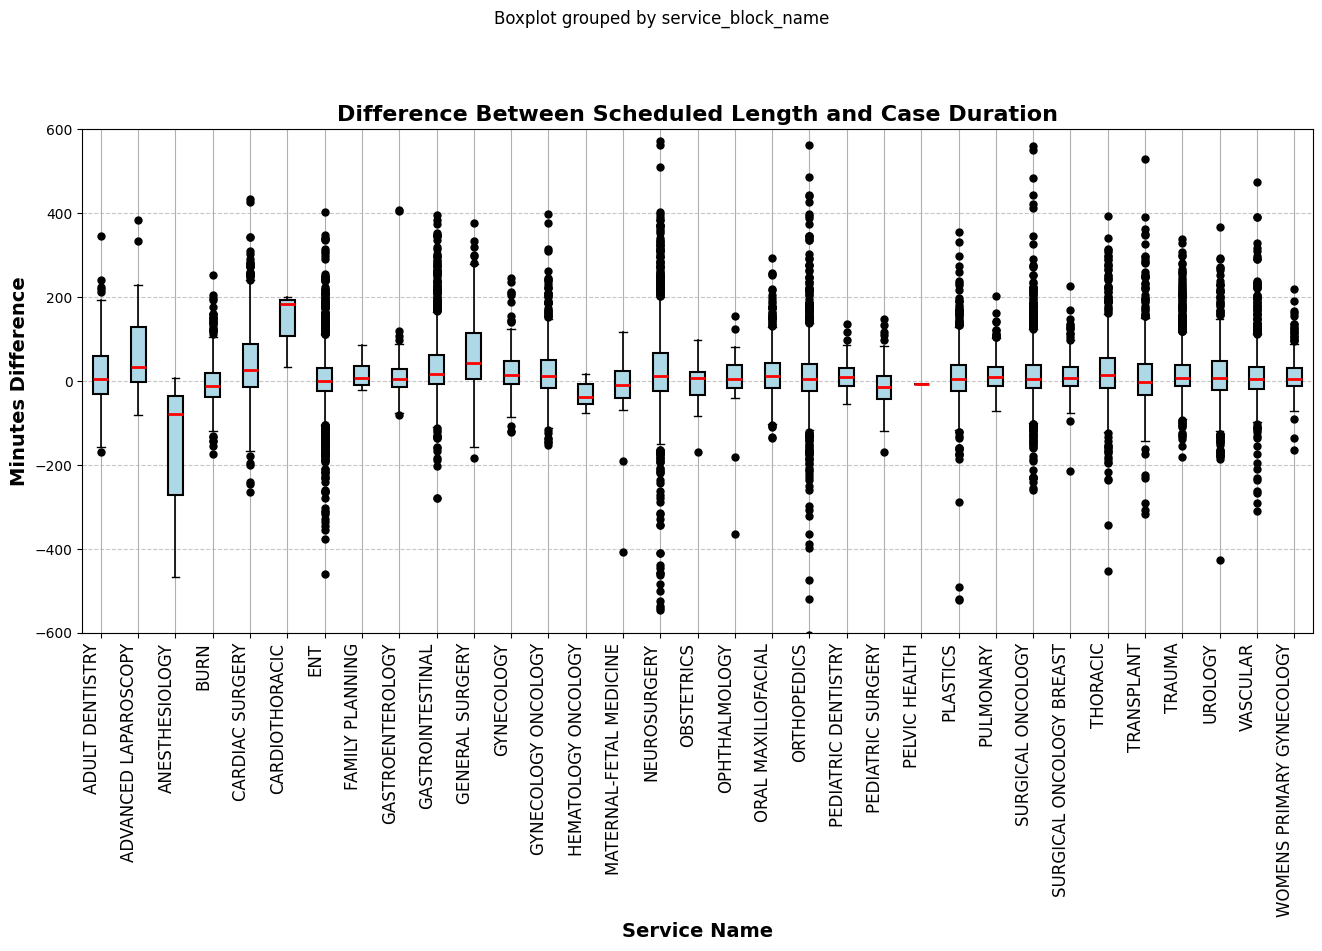

NOTE: DATA DOES NOT INCLUDE SETUP OR TURNOVER TIMES


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the Excel file into a DataFrame named 'df_case' for clarity
import pandas as pd

# #Filter data for location "OR 4TH FL UNCAD"
# df_case = df_case[df_case['location_name'] == 'OR 4TH FL UNCAD']
# df_block = df_block[df_block['location_name'] == 'OR 4TH FL UNCAD']

#read the service block names
service_name=df_block.groupby('service_block_name')

# Calculate total block available minutes
total_block_mins = df_block.groupby('service_block_name')['block_available_mins'].sum()

# Calculate total scheduled minutes
total_sched_mins = df_case.groupby('service_block_name')['sched_minutes'].sum()

# Calculate total case duration minutes
total_case_duration_mins = df_case.groupby('service_block_name')['case_duration'].sum()

time_diff=total_case_duration_mins-total_sched_mins
total_time_diff=sum(time_diff)
print("The total number of minutes different from scheduled vs duration for all services in 2024 is",total_time_diff,"minutes")
total_hrs_diff=total_time_diff/60
print("The total number of hours different from scheduled vs duration for all services in 2024 is",total_hrs_diff,"hours")
total_days_diff=total_hrs_diff/24
print("The total number of days different from scheduled vs duration for all services in 2024 is",total_days_diff,"days")

# Create a DataFrame to store the results

time_distribution = pd.DataFrame({
    'Service Block Name': service_name,
    'Total Block Available Mins': total_block_mins,
    'Total Scheduled Mins': total_sched_mins,
    'Total Case Duration Mins': total_case_duration_mins
})

# Reset the index to make 'service_block_name' a regular column
new_output_file = "Service Time Breakdown.xlsx"
time_distribution.to_excel(new_output_file, index=False)

#Box Plot
fig, ax = plt.subplots(figsize=(14, 10))
fig.subplots_adjust(bottom=0.3)
positions = np.arange(len(sorted_services))
boxplot = df_sorted.boxplot(
    column='time_diff',
    by='service_block_name',
    vert=True,
    positions=positions,
    widths=0.4,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black', linewidth=1.5),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.2, linestyle='-'),
    flierprops=dict(marker='o', markerfacecolor='black', markersize=5, markeredgecolor='black'),
    ax=ax
)
ax.set_ylabel("Minutes Difference", fontsize=14, fontweight='bold')
ax.set_xlabel("Service Name", fontsize=14, fontweight='bold')
ax.set_title("Difference Between Scheduled Length and Case Duration", fontsize=16, fontweight='bold')
ax.set_xticklabels(sorted_services, rotation=90, ha='right', fontsize=12)
ax.set_ylim([-600, 600])
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=3.5)
plt.show()

print("NOTE: DATA DOES NOT INCLUDE SETUP OR TURNOVER TIMES")


# Subset Selction

In [ ]:
#Selecting service subset
selection = input("Please enter one of the following: ALL or SUBSET") # Changed variable name to selection
block = pd.read_excel(excel_file, sheet_name="Block Utilization")

if selection == "ALL":
    # Use all services
  services_to_analyze = block['service_block_name'].unique().tolist()
elif selection == "SUBSET":
    subset_type = input("Enter 'HIGH_PRIORITY' for the pre-identified list or 'MANUAL' to enter your own:").upper()
    if subset_type == "HIGH_PRIORITY":
        services_to_analyze = high_impact_services
    elif subset_type == "MANUAL":
        services_to_analyze = []
        while True:
            service = input("Enter a service name and press enter after each one (or type 'DONE' to finish):")
            if service.upper() == "DONE":
                break
            services_to_analyze.append(service)
    else:
        print("Invalid subset type. Please enter 'HIGH_PRIORITY' or 'MANUAL'.")
        services_to_analyze = []  # Set to empty list to avoid errors later
else:
    print("Invalid selection. Please enter 'ALL' or 'SUBSET'.")
    services_to_analyze = []  # Set to empty list to avoid errors later

print("Services to analyze:", services_to_analyze)


Please enter one of the following: ALL or SUBSETALL
Services to analyze: ['PEDIATRIC SURGERY', 'PLASTICS', 'TRANSPLANT', 'GENERAL SURGERY', 'TRAUMA', 'VASCULAR', 'ORTHOPEDICS', 'UNBLOCKED', 'UROLOGY', 'OPHTHALMOLOGY', 'GASTROINTESTINAL', 'ENT', 'GYNECOLOGY', 'WOMENS PRIMARY GYNECOLOGY', 'ORAL MAXILLOFACIAL', 'GASTROENTEROLOGY', 'BURN', 'NEUROSURGERY', 'URO C BUK/ROS', 'ADVANCED LAPAROSCOPY', 'CARDIOLOGY', 'ADULT DENTISTRY', 'CARDIAC SURGERY', 'SURGICAL ONCOLOGY', 'SURGICAL ONCOLOGY BREAST', 'THORACIC', 'UNCH OR SURGERY BLOCK', 'ENT H&N', 'YAP/HADAR', 'GYN ONC H SOP/DES/BOG', 'ANESTHESIOLOGY', 'PULMONARY', 'PEDIATRIC DENTISTRY', 'GLE/STI', 'HOD/PER', 'BUC/HAC', 'SUL/SCH/HACK', 'GYNECOLOGY ONCOLOGY', 'PEDIATRIC DENTISTRY COMMUNITY', 'GYN GROUP BLOCK', 'BRCA PLASTICS', 'NEURO ELT/QUI', 'DOS DRE/MEY', 'BUC/DED', 'GYN ONC G CLA/LAR', 'BJU/WAL', 'THO/KLA/KIM', 'FAMILY PLANNING', 'EWE/DAV', 'GYN ONC C BRE/BAE', 'REPRODUCTIVE ENDOCRINOLOGY', 'HAD/KRI', 'OBSTETRICS', 'GYN ONC B VAN/DOC/BOG', 'F

In [ ]:
import pandas as pd

# Store user selections in a dictionary for better referencing
user_selections = {}

# User must determine whether to change lead time or allocation
#user_input = input("Enter either 'LT' to simulates changes to lead time or 'ALLOCATION' to simulate changes to allocation: ").upper()
user_input="ALLOCATION"

#if user_input == "LT":
    #change_type = input("Enter 'increase' or 'decrease' to change lead time: ").lower()
    #change_method = input("Enter 'integer days' or 'percent' for the change method: ").lower()
    #time_scale = input("Enter 'overall', 'day of week', or 'week of month' for the time scale: ").lower()

    #user_selections.update({
        #"Lead Time Change": change_type,
        #"Change Method": change_method,
        #"Time Scale": time_scale
    #})

    #if change_method == "integer days":
        #user_selections["Days"] = int(input("Enter the number of days to change lead time by: "))
    #elif change_method == "percent":
        #user_selections["Percent"] = float(input("Enter the percentage to change lead time by: "))

    #if time_scale == "day of week":
        #user_selections["Day of Week"] = input("Enter the day of the week (e.g., MONDAY): ").upper()
    #elif time_scale == "week of month":
        #user_selections["Week of Month"] = int(input("Enter the week of the month (1-5): "))

#elif user_input == "ALLOCATION":
change_type = input("Enter 'increase' or 'decrease' to change allocation: ").lower()
change_method = input("Enter 'number mins' or 'percent' for the change method: ").lower()

# Assign the value to time_scale before using it in the dictionary update
print("Allocation will be measured in mins per week")
time_scale = "mins_per_week"

user_selections.update({
        "Allocation Change": change_type,
        "Change Method": change_method,
        "Time Scale": time_scale
    })

if change_method == "number mins":
        user_selections["Minutes"] = int(input("Enter the number of minutes to change allocation by: "))
elif change_method == "percent":
        user_selections["Percent"] = float(input("Enter the percentage to change allocation by: "))

    #if time_scale == "day of week":
        #user_selections["Day of Week"] = input("Enter the day of the week (e.g., MONDAY): ").upper()
    #elif time_scale == "week of month":
        #user_selections["Week of Month"] = int(input("Enter the week of the month (1-5): "))


# Print selections for debugging
print("\nUser Selections:")
for key, value in user_selections.items():
    print(f"{key}: {value}")

Enter 'increase' or 'decrease' to change allocation: increase
Enter 'number mins' or 'percent' for the change method: number mins
Allocation will be measured in mins per week
Enter the number of minutes to change allocation by: 0

User Selections:
Allocation Change: increase
Change Method: number mins
Time Scale: mins_per_week
Minutes: 0


In [ ]:
##Identifying metrics for improving
import pandas as pd

print("\nReading Current Values...")
print("Services to Analyze:", services_to_analyze)
print("User Selections:", user_selections)

    #If change_type=LT,
    #if user_selections["Change Type"] == "LT":
      #read whether change type is 'increase' or 'decrease'. increase=1, decrease=-1
      #if user_selections["Lead Time Change"] == "increase":
        #change_type=1
      #elif user_selections["Lead Time Change"] == "decrease":
        #change_type=-1
      #read the change type as "percent" or "integer days" and the cooresponding value
      #if user_selections["Change Method"] == "percent":
        #print("Percent")
        #change_method=user_selections["Percent"]
     # elif user_selections["Change Method"] == "integer days":
        #print("Integer days")
    #    change_method=user_selections["Days"]
   #   change_metric=change_type*change_method
    #  print("Change Type:", change_type)
     #$#print("Change Metric:", change_metric)

      #read the time scale
    #  if user_selections["Time Scale"] == "overall":
     #   #read the output_file, sheet "All Data"
      #  df_data = pd.read_excel(output_file_Stats, sheet_name="All Data")
        #for services in services_to_analyze, read column D, "Avg Lead Time"
    #    for service in services_to_analyze:
   #      df_data.loc[df_data["Service"] == service, "Avg Lead Time"]
          #print the selected services names and their lead times in a table
   #       print(df_data.loc[df_data["Service"] == service, ["Service", "Avg Lead Time"]])

    #NOT WORKING CORRETLY, NOT REPORTING VALUE READ!!!!!!!!!!!!!!!!!
   #   user_selections["Time Scale"] == "mins_per_week
    #      print("Reading sheet: Day of Week Averages")
     #     df_data = pd.read_excel(output_file_Stats, sheet_name="Day of Week Averages")
#
 #         selected_day = user_selections["Day of Week"].strip().capitalize()
  #        print(f"User selected day: {selected_day}")

   #       for service_block in services_to_analyze:
    #        print(f"Fetching data for service block: {service_block} on {selected_day}")
     #       service_data = df_data[(df_data["service_block_name"] == service_block) & (df_data["day_of_week"] == selected_day)][["service_block_name", "day_of_week", "Avg Lead Time (Day of Week)"]]

      #      if not service_data.empty:
       #       print("Retrieved data:")
        #      print(service_data.to_string(index=False))
         #   else:
          #    print(f"No data found for service block: {service_block} on {selected_day}")


 #     elif user_selections["Time Scale"]=='week of month':
  #        print("Reading sheet: Week of Month Averages")
   #       df_data = pd.read_excel(output_file_Stats, sheet_name="Week of Month Averages")
    #      selected_week = user_selections["Week of Month"]
     #     for service_block in services_to_analyze:
      #      service_data = df_data[(df_data["service_block_name"] == service_block) & (df_data["week_of_month"] == selected_week)][["service_block_name", "week_of_month", "Avg Lead Time (Week of Month)"]]
     #       if not service_data.empty:
      ##       print(service_data.to_string(index=False))
    #        else:
        #      print(f"No data found for service block: {service_block} on week {selected_week}")

#NOW, FOR ALLOCATION
if user_selections["Allocation Change"] == "increase":
        change_type=1
elif user_selections["Allocation Change"] == "decrease":
        change_type=-1
      #read the change type as "percent" or "integer days" and the cooresponding value
if user_selections["Change Method"] == "percent":
        print("Percent")
        change_method=user_selections["Percent"]
elif user_selections["Change Method"] == "integer days":
        print("Integer days")
        change_method=user_selections["Days"]
change_metric=change_type*change_method
print("Change Type:", change_type)
print("Change Method:", change_method)
print("Change Metric:", change_metric)

#Overall allocation

        #read the output_file, sheet "All Data"
df_data = pd.read_excel(output_file_Stats, sheet_name="Allocation")
        #for services in services_to_analyze, read column D, "Avg Lead Time"
for service in services_to_analyze:
        output_val_allocation = df_data.loc[df_data["service_block_name"] == service, ["service_block_name", "total_weekly_mins"]] # Corrected the line to access columns
          #print the selected services names and their lead times in a table
        print(output_val_allocation)

df_data_LT= pd.read_excel(output_file_Stats, sheet_name="All Data")
for service in services_to_analyze:
        output_val_LT = df_data_LT.loc[df_data_LT["Service"] == service, ["Service", "Avg Lead Time"]]
        print(output_val_LT)
#day of week allocation
      #elif user_selections["Time Scale"] == "day of week":
         # df_data = pd.read_excel(output_file_Stats, sheet_name="Day of Week Allocations")
          #selected_day = user_selections["Day of Week"].strip().capitalize()
         # print(f"User selected day: {selected_day}")
         # for service_block in services_to_analyze:
          #    service_data = df_data[(df_data["service_block_name"] == service_block) & (df_data["day_of_week"] == selected_day)][["service_block_name", "day_of_week", "avg_mins_per_day_of_week"]]  # Fixed column selection
           #   if not service_data.empty:
            #    print(service_data)
             # else:
              #  print(f"No Allocation data found for service block: {service_block} on {selected_day}")

#week of month allocation: CONFIRM WEEK OF MONTH SHEET
    #  elif user_selections["Time Scale"]=='week of month':
     ##    for service_block in services_to_analyze:
      #        service_data = df_data[(df_data["service_block_name"] == service_block) & (df_data["week_of_month"] == selected_week)][["service_block_name", "week_of_month", "avg_mins_per_week_of_month"]]  # Fixed column selection
      #        if not service_data.empty:
       #         print(service_data)
       #       else:
      #          print(f"No Allocation data found for service block: {service_block} on week {selected_week}")




Reading Current Values...
Services to Analyze: ['PEDIATRIC SURGERY', 'PLASTICS', 'TRANSPLANT', 'GENERAL SURGERY', 'TRAUMA', 'VASCULAR', 'ORTHOPEDICS', 'UNBLOCKED', 'UROLOGY', 'OPHTHALMOLOGY', 'GASTROINTESTINAL', 'ENT', 'GYNECOLOGY', 'WOMENS PRIMARY GYNECOLOGY', 'ORAL MAXILLOFACIAL', 'GASTROENTEROLOGY', 'BURN', 'NEUROSURGERY', 'URO C BUK/ROS', 'ADVANCED LAPAROSCOPY', 'CARDIOLOGY', 'ADULT DENTISTRY', 'CARDIAC SURGERY', 'SURGICAL ONCOLOGY', 'SURGICAL ONCOLOGY BREAST', 'THORACIC', 'UNCH OR SURGERY BLOCK', 'ENT H&N', 'YAP/HADAR', 'GYN ONC H SOP/DES/BOG', 'ANESTHESIOLOGY', 'PULMONARY', 'PEDIATRIC DENTISTRY', 'GLE/STI', 'HOD/PER', 'BUC/HAC', 'SUL/SCH/HACK', 'GYNECOLOGY ONCOLOGY', 'PEDIATRIC DENTISTRY COMMUNITY', 'GYN GROUP BLOCK', 'BRCA PLASTICS', 'NEURO ELT/QUI', 'DOS DRE/MEY', 'BUC/DED', 'GYN ONC G CLA/LAR', 'BJU/WAL', 'THO/KLA/KIM', 'FAMILY PLANNING', 'EWE/DAV', 'GYN ONC C BRE/BAE', 'REPRODUCTIVE ENDOCRINOLOGY', 'HAD/KRI', 'OBSTETRICS', 'GYN ONC B VAN/DOC/BOG', 'FRI/SMI/NIE', 'MATERNAL-FE

In [ ]:
#Once the values are read and stored, determine whether user wants to change by % or integer
                        #if %:
                        #multiply current lead time by either (1+%) or (1-%) if pos or neg: "change metric"
                        #output new allocation value and store
                        #if integer:
                        #add/subtract the number of mins per week from the current allocation per week value and store somewhere
  #the output will be the old allocation and the new ideal allocation and current LT


# prompt: From the above store the new allocation as a separate list with the appropriate service

# Assuming 'services_to_analyze' and 'user_selections' are defined as in your original code.

service_data = []  # List to store service-specific data
new_allocation_list = []  # Separate list to store new allocations


for service in services_to_analyze:
    # Retrieve lead time from df_data_LT
    lead_time_row = df_data_LT.loc[df_data_LT["Service"] == service, "Avg Lead Time"]
    lead_time = lead_time_row.iloc[0] if not lead_time_row.empty else 0

    # Retrieve allocation from df_data
    allocation_row = df_data.loc[df_data["service_block_name"] == service, "total_weekly_mins"]
    allocation = allocation_row.iloc[0] if not allocation_row.empty else 0


    if user_selections["Change Method"] == "percent":
        if user_selections["Allocation Change"] == "increase":
            new_alloc = allocation + (allocation * (user_selections["Percent"]/100))
        else:
            new_alloc = allocation - (allocation * (user_selections["Percent"]/100))
    elif user_selections["Change Method"] == "number mins":
        if user_selections["Allocation Change"] == "increase":
            new_alloc = allocation + user_selections["Minutes"]
        else:
            new_alloc = allocation - user_selections["Minutes"]
    else:
        new_alloc = allocation

    new_allocation_list.append([service, new_alloc])  # Append to the new allocation list
    service_data.append([service, lead_time, allocation, new_alloc])


# Create a DataFrame from the collected service data
service_df = pd.DataFrame(service_data, columns=["Service_Name", "Lead Time", "Allocation", "New Allocation"])

# Create a DataFrame from the new allocation list
new_allocation_df = pd.DataFrame(new_allocation_list, columns=["Service_Name", "New Allocation"])

print("\nNew Allocation:")
print(new_allocation_df)

# Optionally, you can also print the service_df DataFrame
print("\nService Data:")
service_df


New Allocation:
                Service_Name  New Allocation
0          PEDIATRIC SURGERY        0.000000
1                   PLASTICS     6405.461538
2                 TRANSPLANT     3675.000000
3            GENERAL SURGERY      915.384615
4                     TRAUMA     8859.137931
..                       ...             ...
70                   HAD/GAL     1284.705882
71                   SIN/ATT     1114.285714
72            ENT G VDRA/MIL        0.000000
73        HOLD - 1WK RELEASE        0.000000
74  HOLD - NO ELECTIVE CASES        0.000000

[75 rows x 2 columns]

Service Data:


,Service_Name,Lead Time,Allocation,New Allocation
0,PEDIATRIC SURGERY,1.757282,0.000000,0.000000
1,PLASTICS,56.368922,6405.461538,6405.461538
2,TRANSPLANT,14.890265,3675.000000,3675.000000
3,GENERAL SURGERY,63.147826,915.384615,915.384615
4,TRAUMA,16.316500,8859.137931,8859.137931
...,...,...,...,...
70,HAD/GAL,0.000000,1284.705882,1284.705882
71,SIN/ATT,0.000000,1114.285714,1114.285714
72,ENT G VDRA/MIL,0.000000,0.000000,0.000000
73,HOLD - 1WK RELEASE,0.000000,0.000000,0.000000


# Block Generator (Weekly)


In [ ]:
##########---Identifies the next monday after date entered. Schedule will begin on that monday---############
from datetime import datetime, timedelta

def next_monday(date):
    # Convert the input date to a datetime object if it's not already
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d')

    # Calculate the number of days until the next Monday
    days_until_monday = (7 - date.weekday() + 0) % 7
    if days_until_monday == 0:
        days_until_monday = 7

    # Find the next Monday
    next_monday_date = date + timedelta(days=days_until_monday)

    return next_monday_date.strftime('%Y-%m-%d')

In [ ]:
# Load pre-existing DataFrame with service and time information

# Copy Selected Service Info
services_df = service_df

# Round up all values in the Avg_Mins column
services_df = services_df.fillna(0)
services_df["New Allocation"] = services_df["New Allocation"].apply(math.ceil)


# Create schedule
######################################################################################################
###################################---USER INPUTS---##################################################

cases = pd.read_excel(excel_file, sheet_name="OR Case Data")
cases = cases.sort_values(by="Day of scheduled_date_of_case_DS")
start = cases.at[0, "Day of scheduled_date_of_case_DS"]
# start = pd.read_excel(excel_file, sheet_name="OR Case Data", usecols=["Day of scheduled_date_of_case_DS"], nrows=1).iloc[0, 0]

sched_len = input("Please enter how many weeks you want to simulate")
######################################################################################################

start_date = datetime.strptime(next_monday(start), "%Y-%m-%d")

data = []
for week in range(1, int(sched_len) + 1):
    week_date = start_date + timedelta(weeks=week - 1)  # Calculate the Monday of the given week

    for _, row in services_df.iterrows():
        data.append([week, week_date, row['Service_Name'], row['New Allocation']])

# Convert to DataFrame
schedule_df = pd.DataFrame(data, columns=["Week", "Week_Date", "Service_Name", "Length"])

#Add additional Columns and their starting values
schedule_df['log_case_id']= None
schedule_df['sched_minutes']= None
schedule_df['Open_mins']= schedule_df['Length']
#schedule_df['Current_Lead_Time']=


# Display the first few rows
print(schedule_df.head())




Please enter how many weeks you want to simulate52
   Week  Week_Date       Service_Name  Length log_case_id sched_minutes  \
0     1 2023-11-27  PEDIATRIC SURGERY       0        None          None   
1     1 2023-11-27           PLASTICS    6406        None          None   
2     1 2023-11-27         TRANSPLANT    3675        None          None   
3     1 2023-11-27    GENERAL SURGERY     916        None          None   
4     1 2023-11-27             TRAUMA    8860        None          None   

   Open_mins  
0          0  
1       6406  
2       3675  
3        916  
4       8860  


# Scheduler Model (Scheduled Minutes)

In [ ]:
import pandas as pd

def copy_specific_columns_to_target():
    # Load and sort Excel data
    df_source = pd.read_excel(excel_file, sheet_name="OR Case Data")
    df_source = df_source.sort_values(by='Day of date_case_scheduled_DS')
    df_source['Day of scheduled_date_of_case_DS'] = ""
    df_source['scheduling_lead_time'] = ""
    df_target = schedule_df.copy()


    # Define mappings
    source_columns = {"log_case_id": "log_case_id", "sched_minutes": "sched_minutes"}
    criteria_column1, sourcecriteria1 = "Open_mins", "sched_minutes"
    criteria_column3, sourcecriteria3 = "Service_Name", "service_block_name"
    criteria_column2, sourcecriteria2 = "Week_Date", "Day of date_case_scheduled_DS"
    surg_date = 'Day of scheduled_date_of_case_DS'


    # Convert df_target to a NumPy array for fast indexing
    df_target_array = df_target.to_numpy()
    open_mins_idx = df_target.columns.get_loc(criteria_column1)
    service_idx = df_target.columns.get_loc(criteria_column3)
    week_date_idx = df_target.columns.get_loc(criteria_column2)


    # Iterate through surgeries and find matches using NumPy filtering
    for _, source_row in df_source.iterrows():
        # Skip source_row if its service is not in service_df
        if source_row[sourcecriteria3] not in service_df[criteria_column3].values:
            continue  # Skip this iteration

        # Compute the warmup cutoff for this service block (i.e. find the current lead time for the service)
        warmup_days = service_df.loc[service_df[criteria_column3] == source_row[sourcecriteria3], "Lead Time"].values[0]
        warmup_days = round(warmup_days,0)
        # Convert lead time to timedelta
        warmup_days = pd.to_timedelta(warmup_days, unit="d")
        warmup_cutoff = start + warmup_days  # Default to 0 if service not found

        # Filter target rows that match the service name and have enough open minutes
        # Service Types must match
        # Block must have enough open time for the surgery
        # Block date must be beyond the warmup period
        # Block date must be in the future
        matches = (df_target_array[:, service_idx] == source_row[sourcecriteria3]) & \
                  (df_target_array[:, open_mins_idx] >= source_row[sourcecriteria1]) & \
                  (df_target_array[:, week_date_idx] > source_row[sourcecriteria2]) & \
                  (df_target_array[:, week_date_idx] > warmup_cutoff)

        if matches.any():
            # Get first matching index
            target_index = matches.argmax()

            # Assign values
            for src_col, tgt_col in source_columns.items():
                col_idx = df_target.columns.get_loc(tgt_col)
                # Append values or update if empty
                if pd.isna(df_target_array[target_index, col_idx]):
                    df_target_array[target_index, col_idx] = source_row[src_col]
                else:
                    if tgt_col == "sched_minutes":
                        df_target_array[target_index, col_idx] += source_row[src_col] + 30
                    else:
                        df_target_array[target_index, col_idx] = f"{df_target_array[target_index, col_idx]}, {source_row[src_col]}"


            # Update open minutes
            df_target_array[target_index, open_mins_idx] -= source_row[sourcecriteria1]

            # Update Surgery Date
            df_source.at[_,'Day of scheduled_date_of_case_DS'] = df_target_array[target_index, week_date_idx]
            df_source.at[_,'scheduling_lead_time'] = df_source.at[_,'Day of scheduled_date_of_case_DS'] - source_row[sourcecriteria2]

    # Convert NumPy array back to DataFrame
    df_target = pd.DataFrame(df_target_array, columns=df_target.columns)

    # Save the updated data
    with pd.ExcelWriter(outfile_file_Updated_Schedule, engine="openpyxl") as writer:
        df_source.to_excel(writer, sheet_name="Case_Data", index=False)
        df_target.to_excel(writer, sheet_name="Block_Group_Assignment", index=False)

    print("Data assignment completed!")

# Call the function
copy_specific_columns_to_target()

<ipython-input-13-bf3de3322652>:46: RuntimeWarning: invalid value encountered in greater_equal
  (df_target_array[:, open_mins_idx] >= source_row[sourcecriteria1]) & \


Data assignment completed!


Faster Code Version 2 with Warmup Period

In [ ]:
import pandas as pd

def copy_specific_columns_to_target():
    # Load the Excel file
    df_source = pd.read_excel(excel_file, sheet_name="OR Case Data")
    df_source = df_source.sort_values(by='Day of date_case_scheduled_DS')  ##--Sort dataframe by scheduling date
    df_target = schedule_df.copy()

    # Define column mappings
    source_columns = {"log_case_id_src": "log_case_id", "sched_minutes_src": "sched_minutes"} # Add suffix to src columns
    criteria_column1, sourcecriteria1 = "Open_mins", "sched_minutes_src"
    criteria_column2, sourcecriteria2 = "Week_Date", "Day of date_case_scheduled_DS"
    criteria_column3, sourcecriteria3 = "Service_Name", "service_block_name"
    op_date_column, case_id_column = "Scheduled_date_of_case", "log_case_id"

    # Set warmup period (e.g., 7 days)
    warmup_period_days = 7
    earliest_schedule_date = df_target[criteria_column2].min()
    warmup_threshold = earliest_schedule_date + pd.Timedelta(days=warmup_period_days)

    # Filter out rows that fall within the warmup period
    df_target = df_target[df_target[criteria_column2] > warmup_threshold]

    # Merge source and target based on service block name
    merged_df = df_source.merge(df_target, left_on=sourcecriteria3, right_on=criteria_column3, suffixes=('_src', '_tgt'))

    # Apply filtering conditions (vectorized)
    valid_matches = merged_df[
        (merged_df[criteria_column1] >= merged_df[sourcecriteria1]) &  # Enough available time
        (merged_df[criteria_column2] > warmup_threshold)  # Beyond warmup period
    ]

    # Efficiently update df_target (surgeries)
    def update_schedule(row):
        target_idx = df_target.index[df_target[criteria_column2] == row[criteria_column2]].tolist()[0]

        # Assign surgery to available block / Update target dataframe
        for src_col, tgt_col in source_columns.items():

            ## Is there already a scheduled surgery in this block?
            # If No, place data for Log_Case_ID and Sched_Mins in empty cells:
            if pd.isna(df_target.at[target_idx, tgt_col]):
                df_target.at[target_idx, tgt_col] = row[src_col]  # Use the appropriate row for the source columns

            # If Yes, add the Log_Case_ID and the Sched_Mins to the pre-existing cell contents:
            else:
                if tgt_col == "sched_minutes":
                    df_target.at[target_idx, tgt_col] += row[src_col]  # Use the appropriate row for the source columns
                else:
                    df_target.at[target_idx, tgt_col] = f"{df_target.at[target_idx, tgt_col]}, {row[src_col]}"

        # Update Open Time for surgery block (remove length of surgery being assigned from the available block time)
        df_target.at[target_idx, criteria_column1] -= row[sourcecriteria1]

    valid_matches.apply(update_schedule, axis=1)  # Apply updates efficiently

    # Save the updated data
    with pd.ExcelWriter("/home/updated2_workbook.xlsx", engine="openpyxl") as writer:
        df_source.to_excel(writer, sheet_name="Case_Data", index=False)
        df_target.to_excel(writer, sheet_name="Block_Group_Assignment", index=False)

    print("Data assignment completed!")

# Call the function
copy_specific_columns_to_target()

Data assignment completed!


# Rerun Descriptive Statistics (Scheduled Minutes)

File successfully saved to /content/ScheduledTimeSimulated.xlsx


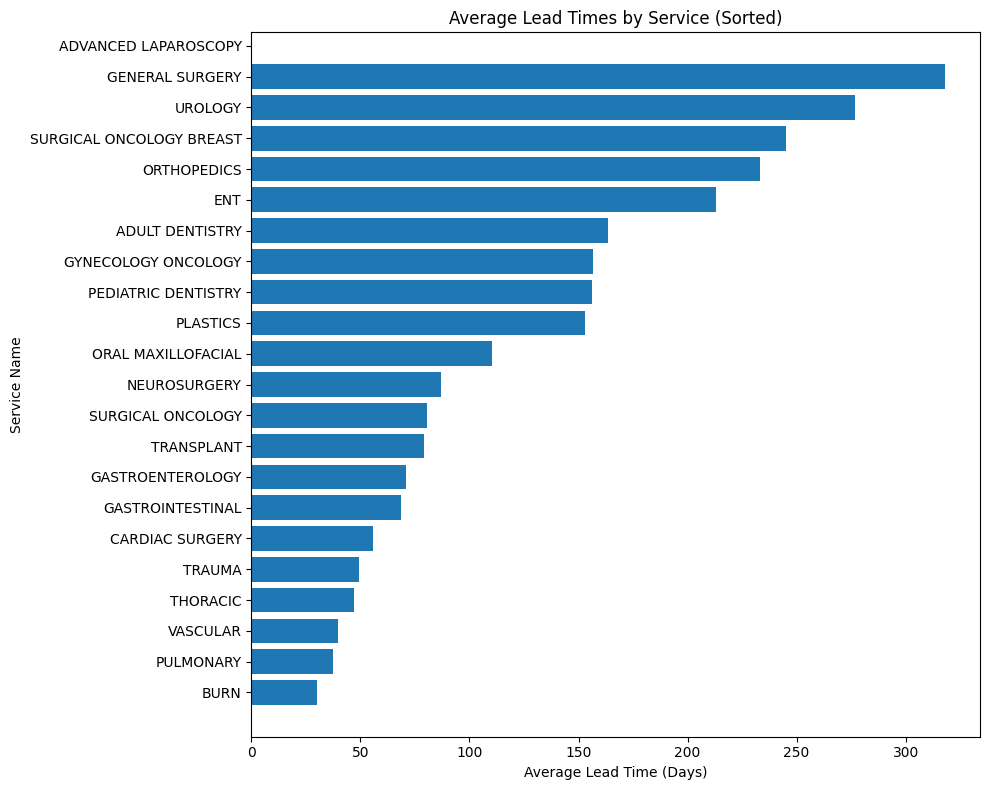

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Read the Excel file
excel_file = "/content/updated_workbook.xlsx"

df = pd.read_excel(excel_file, sheet_name='Case_Data')  # Confirm correct sheet name

# Filter to location (if needed)
df = df[df['location_name'] == 'OR 4TH FL UNCAD']

# Convert 'Day of actual_date_of_procedure_DS' to datetime objects
df['snapshot_date'] = pd.to_datetime(df['Day of actual_date_of_procedure_DS'])
df['week_of_month'] = (df['snapshot_date'].dt.day - 1) // 7 + 1  # Calculate week of the month
df['day_of_week'] = df['snapshot_date'].dt.day_name()  # Extract day of week

# PART 1: OR Case Data Analysis
service_counts = df['service_block_name'].value_counts()
service_sched_minutes = df.groupby('service_block_name')['sched_minutes'].sum()
avg_lead_times = df.groupby('service_block_name')['scheduling_lead_time'].mean()
sd_lead_times = df.groupby('service_block_name')['scheduling_lead_time'].std()

# Identify Key Performance Metrics
all_data_df = pd.DataFrame({
    'Service': service_counts.index,
    'Frequency': service_counts.values,
    'Total Scheduled Minutes': service_sched_minutes.reindex(service_counts.index).values,
    'Avg Lead Time': avg_lead_times.reindex(service_counts.index).values,
    'SD Lead Time': sd_lead_times.reindex(service_counts.index).values,
}).sort_values(by='Service')

# Identify day of week and week of month averages
day_of_week_avg = df.groupby(['service_block_name', 'day_of_week']).agg({
    'sched_minutes': 'mean',
    'scheduling_lead_time': 'mean',
}).reset_index().rename(columns={
    'sched_minutes': 'Avg Scheduled Mins (Day of Week)',
    'scheduling_lead_time': 'Avg Lead Time (Day of Week)',
})

week_of_month_avg = df.groupby(['service_block_name', 'week_of_month']).agg({
    'sched_minutes': 'mean',
    'scheduling_lead_time': 'mean',
}).reset_index().rename(columns={
    'sched_minutes': 'Avg Scheduled Mins (Week of Month)',
    'scheduling_lead_time': 'Avg Lead Time (Week of Month)',
})

# Sort service blocks
df_sorted = df.sort_values(by=['service_block_name'])
sorted_services = sorted(df_sorted['service_block_name'].unique())
positions_dict = {service: i for i, service in enumerate(sorted_services)}

# PART 2: Block Utilization Data Sheet Analysis
df_b = pd.read_excel(excel_file, sheet_name='Block_Group_Assignment')

# Sort by service name and week number
df_b = df_b.sort_values(by=['Service_Name', 'Week'])

# Convert 'Week_Date' to datetime and calculate week of the month
df_b['Week_Date'] = pd.to_datetime(df_b['Week_Date'])
df_b['week_of_month'] = df_b['Week_Date'].dt.isocalendar().week

# Read length per service per week
service_week_length = df_b.groupby(['Service_Name', 'week_of_month'])['Length'].sum()
service_avg_length = df_b.groupby('Service_Name')['Length'].mean()
week_avg_length = df_b.groupby('week_of_month')['Length'].mean()

# Read scheduled minutes per service per week
service_week_sched_mins = df_b.groupby(['Service_Name', 'week_of_month'])['sched_minutes'].sum()
service_avg_sched_mins = df_b.groupby('Service_Name')['sched_minutes'].mean()
week_avg_sched_mins = df_b.groupby('week_of_month')['sched_minutes'].mean()

# Calculate utilization metrics
service_utilization = service_avg_sched_mins / service_avg_length
service_week_utilization = service_week_sched_mins / service_week_length

# Define the correct output file path
outfile_file_Updated_Schedule = "/content/ScheduledTimeSimulated.xlsx"

# Open the Excel writer and save all data to the correct file
with pd.ExcelWriter(outfile_file_Updated_Schedule, engine="openpyxl", mode='w') as writer:
    # Create DataFrame for overall service utilization
    service_utilization_df = pd.DataFrame({
        'Service Name': service_utilization.index,
        'Avg Scheduled Minutes': service_avg_sched_mins.reindex(service_utilization.index).values,
        'Avg Allocated Minutes': service_avg_length.reindex(service_utilization.index).values,
        'Overall Utilization': service_utilization.values
    }).sort_values(by='Service Name')

    # Create DataFrame for utilization per service per week
    service_week_utilization_df = service_week_utilization.reset_index().rename(columns={0: 'Weekly Utilization'})

    # Create DataFrame for overall week-based averages
    week_avg_df = pd.DataFrame({
        'Week of Month': week_avg_sched_mins.index,
        'Avg Scheduled Minutes': week_avg_sched_mins.values,
        'Avg Allocated Minutes': week_avg_length.reindex(week_avg_sched_mins.index).values
    }).sort_values(by='Week of Month')

    # Write DataFrames to respective sheets in the Excel file
    all_data_df.to_excel(writer, sheet_name='All Data', index=False)
    day_of_week_avg.to_excel(writer, sheet_name='Day of Week Averages', index=False)
    week_of_month_avg.to_excel(writer, sheet_name='Week of Month Averages', index=False)
    service_utilization_df.to_excel(writer, sheet_name='Overall Utilization', index=False)
    service_week_utilization_df.to_excel(writer, sheet_name='Weekly Utilization', index=False)
    week_avg_df.to_excel(writer, sheet_name='Week-Based Averages', index=False)

print(f"File successfully saved to {outfile_file_Updated_Schedule}")

# Bar chart of lead times
plt.figure(figsize=(10, 8))
avg_lead_times_sorted = avg_lead_times.sort_values()
plt.barh(avg_lead_times_sorted.index, avg_lead_times_sorted.values)
plt.xlabel("Average Lead Time (Days)")
plt.ylabel("Service Name")
plt.title("Average Lead Times by Service (Sorted)")
plt.tight_layout()
plt.show()


# Scheduler Model (Actual Minutes)

In [ ]:
##########################---Needs to be updated with Actual column references---###############################3

import pandas as pd

def copy_specific_columns_to_target():
    # Load and sort Excel data
    df_source = pd.read_excel(excel_file, sheet_name="OR Case Data")
    df_source = df_source.sort_values(by='Day of date_case_scheduled_DS')
    df_target = schedule_df.copy()


    # Define mappings
    source_columns = {"log_case_id": "log_case_id", "sched_minutes": "sched_minutes"}
    criteria_column1, sourcecriteria1 = "Open_mins", "sched_minutes"
    criteria_column3, sourcecriteria3 = "Service_Name", "service_block_name"
    criteria_column2, sourcecriteria2 = "Week_Date", "Day of date_case_scheduled_DS"


    # Convert df_target to a NumPy array for fast indexing
    df_target_array = df_target.to_numpy()
    open_mins_idx = df_target.columns.get_loc(criteria_column1)
    service_idx = df_target.columns.get_loc(criteria_column3)
    week_date_idx = df_target.columns.get_loc(criteria_column2)


    # Iterate through surgeries and find matches using NumPy filtering
    for _, source_row in df_source.iterrows():
        # Skip source_row if its service is not in service_df
        if source_row[sourcecriteria3] not in service_df[criteria_column3].values:
            continue  # Skip this iteration

        # Compute the warmup cutoff for this service block (i.e. find the current lead time for the service)
        warmup_days = service_df.loc[service_df[criteria_column3] == source_row[sourcecriteria3], "Lead Time"].values[0]
        warmup_days = round(warmup_days,0)
        # Convert lead time to timedelta
        warmup_days = pd.to_timedelta(warmup_days, unit="d")
        warmup_cutoff = start + warmup_days  # Default to 0 if service not found

        # Filter target rows that match the service name and have enough open minutes
        # Service Types must match
        # Block must have enough open time for the surgery
        # Block date must be beyond the warmup period
        # Block date must be in the future
        matches = (df_target_array[:, service_idx] == source_row[sourcecriteria3]) & \
                  (df_target_array[:, open_mins_idx] >= source_row[sourcecriteria1]) & \
                  (df_target_array[:, week_date_idx] > source_row[sourcecriteria2]) & \
                  (df_target_array[:, week_date_idx] > warmup_cutoff)

        if matches.any():
            # Get first matching index
            target_index = matches.argmax()

            # Assign values
            for src_col, tgt_col in source_columns.items():
                col_idx = df_target.columns.get_loc(tgt_col)
                ###############---Need to include setup time?---##################################################
                # Append values or update if empty
                if pd.isna(df_target_array[target_index, col_idx]):
                    df_target_array[target_index, col_idx] = source_row[src_col]
                else:
                    if tgt_col == "sched_minutes":
                        df_target_array[target_index, col_idx] += source_row[src_col]
                    else:
                        df_target_array[target_index, col_idx] = f"{df_target_array[target_index, col_idx]}, {source_row[src_col]}"

            # Update open minutes
            df_target_array[target_index, open_mins_idx] -= source_row[sourcecriteria1]

            # Update Surgery Date
            ###########################################################################
            df_source['Day of scheduled_date_of_case_DS'] =

    # Convert NumPy array back to DataFrame
    df_target = pd.DataFrame(df_target_array, columns=df_target.columns)

    # Save the updated data
    with pd.ExcelWriter(outfile_file_Updated_Schedule, engine="openpyxl") as writer:
        df_source.to_excel(writer, sheet_name="Case_Data", index=False)
        df_target.to_excel(writer, sheet_name="Block_Group_Assignment", index=False)

    print("Data assignment completed!")

# Call the function
copy_specific_columns_to_target()

SyntaxError: invalid syntax (<ipython-input-14-1dee0d903e69>, line 71)

# Rerun Descriptive Statistics (Actual Minutes)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Read the Excel file
excel_file = "/content/updated_workbook.xlsx"

df = pd.read_excel(excel_file, sheet_name='Case_Data')  # Confirm correct sheet name

# Filter to location (if needed)
df = df[df['location_name'] == 'OR 4TH FL UNCAD']

# Convert 'Day of actual_date_of_procedure_DS' to datetime objects
df['snapshot_date'] = pd.to_datetime(df['Day of actual_date_of_procedure_DS'])
df['week_of_month'] = (df['snapshot_date'].dt.day - 1) // 7 + 1  # Calculate week of the month
df['day_of_week'] = df['snapshot_date'].dt.day_name()  # Extract day of week

# PART 1: OR Case Data Analysis
service_counts = df['service_block_name'].value_counts()
service_sched_minutes = df.groupby('service_block_name')['sched_minutes'].sum()
avg_lead_times = df.groupby('service_block_name')['scheduling_lead_time'].mean()
sd_lead_times = df.groupby('service_block_name')['scheduling_lead_time'].std()

# Identify Key Performance Metrics
all_data_df = pd.DataFrame({
    'Service': service_counts.index,
    'Frequency': service_counts.values,
    'Total Scheduled Minutes': service_sched_minutes.reindex(service_counts.index).values,
    'Avg Lead Time': avg_lead_times.reindex(service_counts.index).values,
    'SD Lead Time': sd_lead_times.reindex(service_counts.index).values,
}).sort_values(by='Service')

# Identify day of week and week of month averages
day_of_week_avg = df.groupby(['service_block_name', 'day_of_week']).agg({
    'sched_minutes': 'mean',
    'scheduling_lead_time': 'mean',
}).reset_index().rename(columns={
    'sched_minutes': 'Avg Scheduled Mins (Day of Week)',
    'scheduling_lead_time': 'Avg Lead Time (Day of Week)',
})

week_of_month_avg = df.groupby(['service_block_name', 'week_of_month']).agg({
    'sched_minutes': 'mean',
    'scheduling_lead_time': 'mean',
}).reset_index().rename(columns={
    'sched_minutes': 'Avg Scheduled Mins (Week of Month)',
    'scheduling_lead_time': 'Avg Lead Time (Week of Month)',
})

# Sort service blocks
df_sorted = df.sort_values(by=['service_block_name'])
sorted_services = sorted(df_sorted['service_block_name'].unique())
positions_dict = {service: i for i, service in enumerate(sorted_services)}

# PART 2: Block Utilization Data Sheet Analysis
df_b = pd.read_excel(excel_file, sheet_name='Block_Group_Assignment')

# Sort by service name and week number
df_b = df_b.sort_values(by=['Service_Name', 'Week'])

# Convert 'Week_Date' to datetime and calculate week of the month
df_b['Week_Date'] = pd.to_datetime(df_b['Week_Date'])
df_b['week_of_month'] = df_b['Week_Date'].dt.isocalendar().week

# Read length per service per week
service_week_length = df_b.groupby(['Service_Name', 'week_of_month'])['Length'].sum()
service_avg_length = df_b.groupby('Service_Name')['Length'].mean()
week_avg_length = df_b.groupby('week_of_month')['Length'].mean()

# Read scheduled minutes per service per week
service_week_sched_mins = df_b.groupby(['Service_Name', 'week_of_month'])['sched_minutes'].sum()
service_avg_sched_mins = df_b.groupby('Service_Name')['sched_minutes'].mean()
week_avg_sched_mins = df_b.groupby('week_of_month')['sched_minutes'].mean()

# Calculate utilization metrics
service_utilization = service_avg_sched_mins / service_avg_length
service_week_utilization = service_week_sched_mins / service_week_length

# Define the correct output file path
outfile_file_Updated_Schedule = "/content/ScheduledTimeSimulated.xlsx"

# Open the Excel writer and save all data to the correct file
with pd.ExcelWriter(outfile_file_Updated_Schedule, engine="openpyxl", mode='w') as writer:
    # Create DataFrame for overall service utilization
    service_utilization_df = pd.DataFrame({
        'Service Name': service_utilization.index,
        'Avg Scheduled Minutes': service_avg_sched_mins.reindex(service_utilization.index).values,
        'Avg Allocated Minutes': service_avg_length.reindex(service_utilization.index).values,
        'Overall Utilization': service_utilization.values
    }).sort_values(by='Service Name')

    # Create DataFrame for utilization per service per week
    service_week_utilization_df = service_week_utilization.reset_index().rename(columns={0: 'Weekly Utilization'})

    # Create DataFrame for overall week-based averages
    week_avg_df = pd.DataFrame({
        'Week of Month': week_avg_sched_mins.index,
        'Avg Scheduled Minutes': week_avg_sched_mins.values,
        'Avg Allocated Minutes': week_avg_length.reindex(week_avg_sched_mins.index).values
    }).sort_values(by='Week of Month')

    # Write DataFrames to respective sheets in the Excel file
    all_data_df.to_excel(writer, sheet_name='All Data', index=False)
    day_of_week_avg.to_excel(writer, sheet_name='Day of Week Averages', index=False)
    week_of_month_avg.to_excel(writer, sheet_name='Week of Month Averages', index=False)
    service_utilization_df.to_excel(writer, sheet_name='Overall Utilization', index=False)
    service_week_utilization_df.to_excel(writer, sheet_name='Weekly Utilization', index=False)
    week_avg_df.to_excel(writer, sheet_name='Week-Based Averages', index=False)

print(f"File successfully saved to {outfile_file_Updated_Schedule2}")

# Bar chart of lead times
plt.figure(figsize=(10, 8))
avg_lead_times_sorted = avg_lead_times.sort_values()
plt.barh(avg_lead_times_sorted.index, avg_lead_times_sorted.values)
plt.xlabel("Average Lead Time (Days)")
plt.ylabel("Service Name")
plt.title("Average Lead Times by Service (Sorted)")
plt.tight_layout()
plt.show()
